In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

def plot_error(dados, metricas=['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2'], baseline_name='BASELINE'):
    # Criando um DataFrame a partir dos dados
    df = pd.DataFrame(dados)

    # Filtrando a linha de Baseline
    baseline = df[df['Modelo'] == baseline_name]

    # Removendo a linha de Baseline dos dados para plotagem
    df = df[df['Modelo'] != baseline_name]

    # Configuração do gráfico
    plt.figure(figsize=(16, 8))

    # Loop para plotar cada métrica
    for i, metrica in enumerate(metricas):
        plt.subplot(2, 3, i + 1)

        # Identificar o menor valor de erro (com critério de desempate pelo desvio padrão)
        min_row = df.loc[df[metrica] == df[metrica].min()]
        if len(min_row) > 1:  # Empate: escolhe pelo menor desvio padrão
            min_row = min_row.loc[min_row[f'{metrica}_std'] == min_row[f'{metrica}_std'].min()]
        min_model = min_row.iloc[0]['Modelo']
        min_value = min_row.iloc[0][metrica]
        min_std = min_row.iloc[0][f'{metrica}_std']

        # Plotando os pontos com barras de erro
        plt.errorbar(df['Modelo'], df[metrica], yerr=df[f'{metrica}_std'], fmt='o', label='Método')

        # Destacando o ponto com o menor erro
        plt.errorbar(min_model, min_value, yerr=min_std, fmt='o', color='green', markersize=10, label='Melhor método')

        # Plotando a linha de baseline
        plt.axhline(y=baseline[metrica].values[0], color='r', linestyle='-', label='Baseline')

        # Configurações adicionais
        plt.xticks(rotation=45)
        plt.title(metrica)
        plt.xlabel('Método')
        plt.ylabel('Valor')
        plt.legend()

    plt.tight_layout()
    plt.show()

def format_to_latex_subscript(text):
    # Expressão regular que captura grupos de letras seguidas de números
    return re.sub(r"([A-Z]+)(\d+)", r"\\(\1_\2\\)", text)

def encontrar_menor_metrica(dados, metrica, conjunto_dados):
  """
  Encontra o menor valor de MAPE para um determinado conjunto de dados.

  Args:
    dados: Dicionário com os resultados dos modelos.
    conjunto_dados: Nome do conjunto de dados (e.g., 'Biodiesel Nacional').

  Returns:
    Tupla com o menor valor de MAPE e o modelo correspondente.
  """

  menor_mape = float('inf')
  melhor_modelo = None

  for modelo in dados:
    for configuracao in dados[modelo]:
      if conjunto_dados in dados[modelo][configuracao]:
        if type(dados[modelo][configuracao][conjunto_dados][metrica]) == float:
          mape = dados[modelo][configuracao][conjunto_dados][metrica]
        else:
          mape = dados[modelo][configuracao][conjunto_dados][metrica][0]
        if mape < menor_mape:
          menor_mape = mape

  return menor_mape

def generate_latex_table (dados, metricas, datasets, num_casas_decimais):
  text = """\\begin{tabular}{ll""" + 'c'*len(metricas)*len(datasets) + """}
    \\toprule
    \\multicolumn{2}{c}{\\textbf{Modelo}} & """

  text += ' & '.join([f'\\multicolumn{{{len(metricas)}}}{{c}}{{\\textbf{{{dataset}}}}}' for dataset in datasets]) + ' \\\ \n'
  col_starts = 3
  for i in range(len(datasets)):
    text += f'\cmidrule(lr){{{col_starts}-{col_starts+len(metricas)-1}}} '
    col_starts += len(metricas)
  text += '\n & ' + (' & ' + ' & '.join([f'{format_to_latex_subscript(metrica)}' for metrica in metricas]))*len(datasets) + ' \\\ \n'
  text += '\\midrule\n'
  for i, model in enumerate(dados.keys()):
    text += f'\\multirow{{{len(dados[model])}}}' + '{*}{\\ac{' + model + '}}\n'
    for config in dados[model].keys():
      text += ' & ' + config
      for dataset in datasets:
        for metrica in metricas:
          text += ' & '
          if type(dados[model][config][dataset][metrica]) == float:
            text += ('\\textbf{' if encontrar_menor_metrica(dados, metrica, dataset) == dados[model][config][dataset][metrica] else "") + (f'{dados[model][config][dataset][metrica]:.{num_casas_decimais}f}' if not np.isnan(dados[model][config][dataset][metrica]) else '---').replace('.', ',') + ('}' if encontrar_menor_metrica(dados, metrica, dataset) == dados[model][config][dataset][metrica] else "")
          else:
            text += ('\\textbf{' if encontrar_menor_metrica(dados, metrica, dataset) == dados[model][config][dataset][metrica][0] else "") + (f'\\({dados[model][config][dataset][metrica][0]:.{num_casas_decimais}f} \\pm {dados[model][config][dataset][metrica][1]:.{num_casas_decimais}f}\\)' if not np.isnan(dados[model][config][dataset][metrica][1]) else (f'{dados[model][config][dataset][metrica][0]:.{num_casas_decimais}f}' if not np.isnan(dados[model][config][dataset][metrica][0]) else '---')).replace('.', ',') + ('}' if encontrar_menor_metrica(dados, metrica, dataset) == dados[model][config][dataset][metrica][0] else "")
      text += ' \\\ \n'
    text += '\\midrule\n' if i != len(dados.keys()) - 1 else '\\bottomrule\n'

  text += '\end{tabular}'
  text = re.sub(
    r"\\textbf{\\\(([\d,]+) \\pm ([\d,]+)\\\)}",
    r"\(\\mathbf{\1} \\pm \\mathbf{\2}\)",
    text
)

  # Substituição para \textbf{valor} para \mathbf{valor}
  texto = re.sub(
      r"\\textbf{([\d,]+)}",
      r"\\mathbf{\1}",
      text
  )
  return text

In [ ]:

def parse_metrics(text):
    # Extrair as métricas de cross-validation
    cv_metrics = {}
    cv_pattern = r"(\w+) -> Média: ([\d.]+), Desvio Padrão: ([\d.]+)"
    for match in re.finditer(cv_pattern, text):
        metric, mean, std_dev = match.groups()
        cv_metrics[metric] = (float(mean), float(std_dev))

    # Extrair as métricas de teste
    test_metrics = {}
    test_pattern = r"(\w+) -> ([\d.]+)"
    test_section = text.split("Teste:")[-1]
    for match in re.finditer(test_pattern, test_section):
        metric, value = match.groups()
        test_metrics[metric] = float(value)

    return cv_metrics, test_metrics

arima = {
    "MAPE": 15.79,
    "MSE": 0.87,
    "RMSE": 0.93,
    "SLE": 4.21,
    "U1": np.nan,
    "U2": np.nan,
}

narx_brasil_sliding_window_cross_validation, narx_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 5.722215, Desvio Padrão: 0.559275, Percentis: 1st: 5.232794, 5th: 5.249196, 50th: 5.433709, 95th: 6.397189, 99th: 6.482832
SLE -> Média: 0.113029, Desvio Padrão: 0.036871, Percentis: 1st: 0.084300, 5th: 0.084751, 50th: 0.089829, 95th: 0.157547, 99th: 0.163567
RMSE -> Média: 0.372969, Desvio Padrão: 0.080913, Percentis: 1st: 0.267040, 5th: 0.277561, 50th: 0.395915, 95th: 0.452315, 99th: 0.457328
MSE -> Média: 0.149634, Desvio Padrão: 0.058080, Percentis: 1st: 0.076399, 5th: 0.083051, 50th: 0.157881, 95th: 0.210444, 99th: 0.215117
U1 -> Média: 0.965631, Desvio Padrão: 0.035572, Percentis: 1st: 0.937594, 5th: 0.938085, 50th: 0.943610, 95th: 1.008591, 99th: 1.014367
U2 -> Média: 1.368422, Desvio Padrão: 0.493793, Percentis: 1st: 0.713524, 5th: 0.780911, 50th: 1.539017, 95th: 1.836516, 99th: 1.862961
Teste:
MAPE -> 6.245349
SLE -> 0.320813
RMSE -> 0.326679
MSE -> 0.108272
U1 -> 0.876967
U2 -> 2.438743
"""
)

darnn_brasil_sliding_window_cross_validation, darnn_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 5.295202, Desvio Padrão: 2.696238, Percentis: 1st: 2.652888, 5th: 2.868587, 50th: 5.295202, 95th: 7.721816, 99th: 7.937515
SLE -> Média: 0.106572, Desvio Padrão: 0.085695, Percentis: 1st: 0.022591, 5th: 0.029447, 50th: 0.106572, 95th: 0.183698, 99th: 0.190553
RMSE -> Média: 0.340933, Desvio Padrão: 0.199961, Percentis: 1st: 0.144971, 5th: 0.160968, 50th: 0.340933, 95th: 0.520898, 99th: 0.536894
MSE -> Média: 0.156220, Desvio Padrão: 0.136346, Percentis: 1st: 0.022600, 5th: 0.033508, 50th: 0.156220, 95th: 0.278931, 99th: 0.289839
U1 -> Média: 0.695274, Desvio Padrão: 0.013560, Percentis: 1st: 0.681986, 5th: 0.683070, 50th: 0.695274, 95th: 0.707478, 99th: 0.708563
U2 -> Média: 3.913649, Desvio Padrão: 0.969205, Percentis: 1st: 2.963828, 5th: 3.041365, 50th: 3.913649, 95th: 4.785933, 99th: 4.863470
Teste:
MAPE -> 3.339350
SLE -> 0.108997
RMSE -> 0.197407
MSE -> 0.038969
U1 -> 0.302031
U2 -> 1.898322
"""
)

mlp_brasil_sliding_window_cross_validation, mlp_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 4.449031, Desvio Padrão: 2.225296, Percentis: 1st: 2.268241, 5th: 2.446265, 50th: 4.449031, 95th: 6.451798, 99th: 6.629821
SLE -> Média: 0.099564, Desvio Padrão: 0.080756, Percentis: 1st: 0.020424, 5th: 0.026884, 50th: 0.099564, 95th: 0.172245, 99th: 0.178705
RMSE -> Média: 0.303319, Desvio Padrão: 0.178032, Percentis: 1st: 0.128848, 5th: 0.143090, 50th: 0.303319, 95th: 0.463548, 99th: 0.477791
MSE -> Média: 0.123698, Desvio Padrão: 0.108001, Percentis: 1st: 0.017857, 5th: 0.026497, 50th: 0.123698, 95th: 0.220899, 99th: 0.229539
U1 -> Média: 0.801360, Desvio Padrão: 0.096509, Percentis: 1st: 0.706782, 5th: 0.714503, 50th: 0.801360, 95th: 0.888218, 99th: 0.895939
U2 -> Média: 1.741841, Desvio Padrão: 0.370476, Percentis: 1st: 1.378774, 5th: 1.408412, 50th: 1.741841, 95th: 2.075269, 99th: 2.104907
Teste:
MAPE -> 3.118405
SLE -> 0.092628
RMSE -> 0.179806
MSE -> 0.032330
U1 -> 0.318169
U2 -> 1.996668
"""
)

imp_brasil_sliding_window_cross_validation, imp_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 9.422459, Desvio Padrão: 2.956437, Percentis: 1st: 6.525150, 5th: 6.761665, 50th: 9.422459, 95th: 12.083252, 99th: 12.319767
SLE -> Média: 0.267205, Desvio Padrão: 0.139524, Percentis: 1st: 0.130472, 5th: 0.141634, 50th: 0.267205, 95th: 0.392777, 99th: 0.403939
RMSE -> Média: 0.568008, Desvio Padrão: 0.231656, Percentis: 1st: 0.340986, 5th: 0.359518, 50th: 0.568008, 95th: 0.776498, 99th: 0.795031
MSE -> Média: 0.376298, Desvio Padrão: 0.263164, Percentis: 1st: 0.118396, 5th: 0.139450, 50th: 0.376298, 95th: 0.613146, 99th: 0.634199
U1 -> Média: 0.868738, Desvio Padrão: 0.151494, Percentis: 1st: 0.720274, 5th: 0.732393, 50th: 0.868738, 95th: 1.005082, 99th: 1.017202
U2 -> Média: 5.753769, Desvio Padrão: 1.238477, Percentis: 1st: 4.540062, 5th: 4.639140, 50th: 5.753769, 95th: 6.868398, 99th: 6.967477
Teste:
MAPE -> 5.583708
SLE -> 0.306588
RMSE -> 0.314752
MSE -> 0.099069
U1 -> 0.567271
U2 -> 2.313975
"""
)

idln_brasil_sliding_window_cross_validation, idln_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 4.988026, Desvio Padrão: 2.474008, Percentis: 1st: 2.563499, 5th: 2.761419, 50th: 4.988026, 95th: 7.214633, 99th: 7.412554
SLE -> Média: 0.088714, Desvio Padrão: 0.066341, Percentis: 1st: 0.023700, 5th: 0.029007, 50th: 0.088714, 95th: 0.148420, 99th: 0.153728
RMSE -> Média: 0.312366, Desvio Padrão: 0.171508, Percentis: 1st: 0.144288, 5th: 0.158009, 50th: 0.312366, 95th: 0.466723, 99th: 0.480443
MSE -> Média: 0.126987, Desvio Padrão: 0.107146, Percentis: 1st: 0.021984, 5th: 0.030556, 50th: 0.126987, 95th: 0.223419, 99th: 0.231991
U1 -> Média: 0.730383, Desvio Padrão: 0.110366, Percentis: 1st: 0.622224, 5th: 0.631053, 50th: 0.730383, 95th: 0.829712, 99th: 0.838542
U2 -> Média: 3.288663, Desvio Padrão: 2.145825, Percentis: 1st: 1.185755, 5th: 1.357421, 50th: 3.288663, 95th: 5.219906, 99th: 5.391572
Teste:
MAPE -> 3.423223
SLE -> 0.104050
RMSE -> 0.192349
MSE -> 0.036998
U1 -> 0.321345
U2 -> 1.083492
"""
)

nlinear_brasil_sliding_window_cross_validation, nlinear_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 3.092829, Desvio Padrão: 1.559141, Percentis: 1st: 1.564870, 5th: 1.689601, 50th: 3.092829, 95th: 4.496056, 99th: 4.620787
SLE -> Média: 0.045852, Desvio Padrão: 0.036312, Percentis: 1st: 0.010267, 5th: 0.013172, 50th: 0.045852, 95th: 0.078533, 99th: 0.081438
RMSE -> Média: 0.207647, Desvio Padrão: 0.118788, Percentis: 1st: 0.091235, 5th: 0.100738, 50th: 0.207647, 95th: 0.314556, 99th: 0.324059
MSE -> Média: 0.057228, Desvio Padrão: 0.049332, Percentis: 1st: 0.008883, 5th: 0.012829, 50th: 0.057228, 95th: 0.101626, 99th: 0.105573
U1 -> Média: 0.466623, Desvio Padrão: 0.030028, Percentis: 1st: 0.437195, 5th: 0.439598, 50th: 0.466623, 95th: 0.493648, 99th: 0.496050
U2 -> Média: 2.279787, Desvio Padrão: 1.066530, Percentis: 1st: 1.234587, 5th: 1.319910, 50th: 2.279787, 95th: 3.239664, 99th: 3.324986
Teste:
MAPE -> 1.723333
SLE -> 0.028322
RMSE -> 0.100374
MSE -> 0.010075
U1 -> 0.161709
U2 -> 0.497819
"""
)

nhits_brasil_sliding_window_cross_validation, nhits_brasil_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 4.754333, Desvio Padrão: 0.912691, Percentis: 1st: 3.859896, 5th: 3.932912, 50th: 4.754333, 95th: 5.575755, 99th: 5.648770
SLE -> Média: 0.088923, Desvio Padrão: 0.046751, Percentis: 1st: 0.043107, 5th: 0.046847, 50th: 0.088923, 95th: 0.130999, 99th: 0.134739
RMSE -> Média: 0.308534, Desvio Padrão: 0.117954, Percentis: 1st: 0.192939, 5th: 0.202376, 50th: 0.308534, 95th: 0.414693, 99th: 0.424130
MSE -> Média: 0.109107, Desvio Padrão: 0.072786, Percentis: 1st: 0.037776, 5th: 0.043599, 50th: 0.109107, 95th: 0.174614, 99th: 0.180437
U1 -> Média: 0.947402, Desvio Padrão: 0.051310, Percentis: 1st: 0.897118, 5th: 0.901223, 50th: 0.947402, 95th: 0.993580, 99th: 0.997685
U2 -> Média: 2.046782, Desvio Padrão: 1.024093, Percentis: 1st: 1.043171, 5th: 1.125099, 50th: 2.046782, 95th: 2.968466, 99th: 3.050393
Teste:
MAPE -> 3.982015
SLE -> 0.151272
RMSE -> 0.229251
MSE -> 0.052556
U1 -> 0.409458
U2 -> 2.061497
"""
)

narx_brasil_detrend_sliding_window_cross_validation, narx_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 9.679639, Desvio Padrão: 5.259831, Percentis: 1st: 4.525004, 5th: 4.945791, 50th: 9.679639, 95th: 14.413486, 99th: 14.834273
SLE -> Média: 0.485169, Desvio Padrão: 0.358637, Percentis: 1st: 0.133705, 5th: 0.162396, 50th: 0.485169, 95th: 0.807942, 99th: 0.836633
RMSE -> Média: 0.588672, Desvio Padrão: 0.357064, Percentis: 1st: 0.238749, 5th: 0.267314, 50th: 0.588672, 95th: 0.910029, 99th: 0.938594
MSE -> Média: 0.515507, Desvio Padrão: 0.433660, Percentis: 1st: 0.090520, 5th: 0.125213, 50th: 0.515507, 95th: 0.905801, 99th: 0.940494
U1 -> Média: 0.828839, Desvio Padrão: 0.369714, Percentis: 1st: 0.466520, 5th: 0.496097, 50th: 0.828839, 95th: 1.161581, 99th: 1.191159
U2 -> Média: 2.839293, Desvio Padrão: 2.150764, Percentis: 1st: 0.731544, 5th: 0.903605, 50th: 2.839293, 95th: 4.774981, 99th: 4.947042
Teste:
MAPE -> 4.970119
SLE -> 0.417039
RMSE -> 0.316237
MSE -> 0.133592
U1 -> 0.785983
U2 -> 1.037881
"""
)

darnn_brasil_detrend_sliding_window_cross_validation, darnn_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 6.849743, Desvio Padrão: 4.139677, Percentis: 1st: 2.792860, 5th: 3.124034, 50th: 6.849743, 95th: 10.575453, 99th: 10.906627
SLE -> Média: 0.249750, Desvio Padrão: 0.223549, Percentis: 1st: 0.030672, 5th: 0.048556, 50th: 0.249750, 95th: 0.450945, 99th: 0.468829
RMSE -> Média: 0.447915, Desvio Padrão: 0.308423, Percentis: 1st: 0.145661, 5th: 0.170335, 50th: 0.447915, 95th: 0.725496, 99th: 0.750170
MSE -> Média: 0.295753, Desvio Padrão: 0.276295, Percentis: 1st: 0.024984, 5th: 0.047088, 50th: 0.295753, 95th: 0.544418, 99th: 0.566521
U1 -> Média: 0.741957, Desvio Padrão: 0.373063, Percentis: 1st: 0.376355, 5th: 0.406200, 50th: 0.741957, 95th: 1.077714, 99th: 1.107559
U2 -> Média: 2.727145, Desvio Padrão: 0.511933, Percentis: 1st: 2.225451, 5th: 2.266406, 50th: 2.727145, 95th: 3.187885, 99th: 3.228839
Teste:
MAPE -> 1.871337
SLE -> 0.030771
RMSE -> 0.103003
MSE -> 0.010610
U1 -> 0.265674
U2 -> 0.638253
"""
)

mlp_brasil_detrend_sliding_window_cross_validation, mlp_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 5.922931, Desvio Padrão: 3.407819, Percentis: 1st: 2.583268, 5th: 2.855894, 50th: 5.922931, 95th: 8.989968, 99th: 9.262593
SLE -> Média: 0.154320, Desvio Padrão: 0.132130, Percentis: 1st: 0.024832, 5th: 0.035403, 50th: 0.154320, 95th: 0.273237, 99th: 0.283807
RMSE -> Média: 0.367298, Desvio Padrão: 0.233565, Percentis: 1st: 0.138404, 5th: 0.157089, 50th: 0.367298, 95th: 0.577506, 99th: 0.596191
MSE -> Média: 0.189460, Desvio Padrão: 0.171576, Percentis: 1st: 0.021316, 5th: 0.035042, 50th: 0.189460, 95th: 0.343878, 99th: 0.357604
U1 -> Média: 0.601142, Desvio Padrão: 0.278209, Percentis: 1st: 0.328497, 5th: 0.350754, 50th: 0.601142, 95th: 0.851530, 99th: 0.873787
U2 -> Média: 1.603870, Desvio Padrão: 0.681663, Percentis: 1st: 0.935840, 5th: 0.990373, 50th: 1.603870, 95th: 2.217367, 99th: 2.271900
Teste:
MAPE -> 1.577157
SLE -> 0.024655
RMSE -> 0.092612
MSE -> 0.008577
U1 -> 0.237753
U2 -> 0.206923
"""
)

imp_brasil_detrend_sliding_window_cross_validation, imp_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 8.682385, Desvio Padrão: 1.779339, Percentis: 1st: 6.938633, 5th: 7.080980, 50th: 8.682385, 95th: 10.283790, 99th: 10.426137
SLE -> Média: 0.390231, Desvio Padrão: 0.123433, Percentis: 1st: 0.269267, 5th: 0.279141, 50th: 0.390231, 95th: 0.501320, 99th: 0.511195
RMSE -> Média: 0.590115, Desvio Padrão: 0.183575, Percentis: 1st: 0.410212, 5th: 0.424898, 50th: 0.590115, 95th: 0.755333, 99th: 0.770019
MSE -> Média: 0.381936, Desvio Padrão: 0.216661, Percentis: 1st: 0.169609, 5th: 0.186941, 50th: 0.381936, 95th: 0.576930, 99th: 0.594263
U1 -> Média: 1.033538, Desvio Padrão: 0.136603, Percentis: 1st: 0.899668, 5th: 0.910596, 50th: 1.033538, 95th: 1.156481, 99th: 1.167409
U2 -> Média: 1.841532, Desvio Padrão: 0.187849, Percentis: 1st: 1.657441, 5th: 1.672468, 50th: 1.841532, 95th: 2.010596, 99th: 2.025624
Teste:
MAPE -> 7.843942
SLE -> 0.896481
RMSE -> 0.477606
MSE -> 0.228107
U1 -> 1.084126
U2 -> 1.154521
"""
)

idln_brasil_detrend_sliding_window_cross_validation, idln_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 4.849508, Desvio Padrão: 2.307151, Percentis: 1st: 2.588501, 5th: 2.773073, 50th: 4.849508, 95th: 6.925944, 99th: 7.110516
SLE -> Média: 0.111285, Desvio Padrão: 0.090221, Percentis: 1st: 0.022869, 5th: 0.030086, 50th: 0.111285, 95th: 0.192484, 99th: 0.199702
RMSE -> Média: 0.316757, Desvio Padrão: 0.192452, Percentis: 1st: 0.128155, 5th: 0.143551, 50th: 0.316757, 95th: 0.489964, 99th: 0.505360
MSE -> Média: 0.137373, Desvio Padrão: 0.121921, Percentis: 1st: 0.017890, 5th: 0.027644, 50th: 0.137373, 95th: 0.247102, 99th: 0.256855
U1 -> Média: 0.589556, Desvio Padrão: 0.195658, Percentis: 1st: 0.397811, 5th: 0.413464, 50th: 0.589556, 95th: 0.765648, 99th: 0.781300
U2 -> Média: 2.059000, Desvio Padrão: 0.930689, Percentis: 1st: 1.146925, 5th: 1.221380, 50th: 2.059000, 95th: 2.896621, 99th: 2.971076
Teste:
MAPE -> 1.662744
SLE -> 0.028678
RMSE -> 0.098016
MSE -> 0.009607
U1 -> 0.274744
U2 -> 0.170024
"""
)

nlinear_brasil_detrend_sliding_window_cross_validation, nlinear_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 3.737839, Desvio Padrão: 2.338179, Percentis: 1st: 1.446423, 5th: 1.633478, 50th: 3.737839, 95th: 5.842200, 99th: 6.029254
SLE -> Média: 0.095925, Desvio Padrão: 0.088556, Percentis: 1st: 0.009140, 5th: 0.016225, 50th: 0.095925, 95th: 0.175626, 99th: 0.182710
RMSE -> Média: 0.275428, Desvio Padrão: 0.200162, Percentis: 1st: 0.079269, 5th: 0.095282, 50th: 0.275428, 95th: 0.455574, 99th: 0.471587
MSE -> Média: 0.115925, Desvio Padrão: 0.110260, Percentis: 1st: 0.007870, 5th: 0.016691, 50th: 0.115925, 95th: 0.215160, 99th: 0.223981
U1 -> Média: 0.357785, Desvio Padrão: 0.151184, Percentis: 1st: 0.209625, 5th: 0.221720, 50th: 0.357785, 95th: 0.493850, 99th: 0.505945
U2 -> Média: 1.849396, Desvio Padrão: 1.378044, Percentis: 1st: 0.498912, 5th: 0.609156, 50th: 1.849396, 95th: 3.089636, 99th: 3.199879
Teste:
MAPE -> 1.471316
SLE -> 0.020982
RMSE -> 0.085362
MSE -> 0.007287
U1 -> 0.217610
U2 -> 0.096556
"""
)

nhits_brasil_detrend_sliding_window_cross_validation, nhits_brasil_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 6.853359, Desvio Padrão: 3.128807, Percentis: 1st: 3.787127, 5th: 4.037432, 50th: 6.853359, 95th: 9.669285, 99th: 9.919590
SLE -> Média: 0.215520, Desvio Padrão: 0.158152, Percentis: 1st: 0.060531, 5th: 0.073183, 50th: 0.215520, 95th: 0.357857, 99th: 0.370510
RMSE -> Média: 0.438879, Desvio Padrão: 0.241787, Percentis: 1st: 0.201927, 5th: 0.221270, 50th: 0.438879, 95th: 0.656488, 99th: 0.675831
MSE -> Média: 0.251076, Desvio Padrão: 0.212231, Percentis: 1st: 0.043090, 5th: 0.060068, 50th: 0.251076, 95th: 0.442084, 99th: 0.459062
U1 -> Média: 0.821602, Desvio Padrão: 0.243154, Percentis: 1st: 0.583311, 5th: 0.602763, 50th: 0.821602, 95th: 1.040440, 99th: 1.059893
U2 -> Média: 1.748094, Desvio Padrão: 0.698803, Percentis: 1st: 1.063267, 5th: 1.119171, 50th: 1.748094, 95th: 2.377017, 99th: 2.432921
Teste:
MAPE -> 2.424696
SLE -> 0.056778
RMSE -> 0.136346
MSE -> 0.018590
U1 -> 0.393406
U2 -> 0.188706
"""
)

narx_brasil_soybean_sliding_window_cross_validation, narx_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.551563, Desvio Padrão: 0.115491, Percentis: 1st: 1.438382, 5th: 1.447621, 50th: 1.551563, 95th: 1.655504, 99th: 1.664744
SLE -> Média: 0.009438, Desvio Padrão: 0.001540, Percentis: 1st: 0.007929, 5th: 0.008052, 50th: 0.009438, 95th: 0.010824, 99th: 0.010948
RMSE -> Média: 0.099532, Desvio Padrão: 0.006256, Percentis: 1st: 0.093401, 5th: 0.093902, 50th: 0.099532, 95th: 0.105162, 99th: 0.105663
MSE -> Média: 0.009946, Desvio Padrão: 0.001245, Percentis: 1st: 0.008725, 5th: 0.008825, 50th: 0.009946, 95th: 0.011067, 99th: 0.011166
U1 -> Média: 0.323840, Desvio Padrão: 0.178696, Percentis: 1st: 0.148718, 5th: 0.163014, 50th: 0.323840, 95th: 0.484666, 99th: 0.498962
U2 -> Média: 1.205855, Desvio Padrão: 0.094257, Percentis: 1st: 1.113483, 5th: 1.121024, 50th: 1.205855, 95th: 1.290686, 99th: 1.298227
Teste:
MAPE -> 2.229713
SLE -> 0.048218
RMSE -> 0.130026
MSE -> 0.016907
U1 -> 0.208652
U2 -> 0.593951
"""
)

darnn_brasil_soybean_sliding_window_cross_validation, darnn_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.934370, Desvio Padrão: 0.068405, Percentis: 1st: 1.867333, 5th: 1.872806, 50th: 1.934370, 95th: 1.995935, 99th: 2.001407
SLE -> Média: 0.013173, Desvio Padrão: 0.000419, Percentis: 1st: 0.012763, 5th: 0.012796, 50th: 0.013173, 95th: 0.013550, 99th: 0.013584
RMSE -> Média: 0.116874, Desvio Padrão: 0.017656, Percentis: 1st: 0.099571, 5th: 0.100984, 50th: 0.116874, 95th: 0.132764, 99th: 0.134177
MSE -> Média: 0.013971, Desvio Padrão: 0.004127, Percentis: 1st: 0.009927, 5th: 0.010257, 50th: 0.013971, 95th: 0.017686, 99th: 0.018016
U1 -> Média: 0.358240, Desvio Padrão: 0.167789, Percentis: 1st: 0.193806, 5th: 0.207229, 50th: 0.358240, 95th: 0.509250, 99th: 0.522674
U2 -> Média: 1.795542, Desvio Padrão: 0.041576, Percentis: 1st: 1.754798, 5th: 1.758124, 50th: 1.795542, 95th: 1.832961, 99th: 1.836287
Teste:
MAPE -> 3.605375
SLE -> 0.133657
RMSE -> 0.217388
MSE -> 0.047257
U1 -> 0.345726
U2 -> 2.747316
"""
)

mlp_brasil_soybean_sliding_window_cross_validation, mlp_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.272764, Desvio Padrão: 0.016753, Percentis: 1st: 1.256347, 5th: 1.257687, 50th: 1.272764, 95th: 1.287842, 99th: 1.289182
SLE -> Média: 0.006684, Desvio Padrão: 0.000387, Percentis: 1st: 0.006304, 5th: 0.006335, 50th: 0.006684, 95th: 0.007032, 99th: 0.007063
RMSE -> Média: 0.083214, Desvio Padrão: 0.013657, Percentis: 1st: 0.069830, 5th: 0.070923, 50th: 0.083214, 95th: 0.095506, 99th: 0.096599
MSE -> Média: 0.007111, Desvio Padrão: 0.002273, Percentis: 1st: 0.004884, 5th: 0.005065, 50th: 0.007111, 95th: 0.009157, 99th: 0.009339
U1 -> Média: 0.271895, Desvio Padrão: 0.127960, Percentis: 1st: 0.146494, 5th: 0.156731, 50th: 0.271895, 95th: 0.387059, 99th: 0.397296
U2 -> Média: 0.934690, Desvio Padrão: 0.051852, Percentis: 1st: 0.883875, 5th: 0.888023, 50th: 0.934690, 95th: 0.981357, 99th: 0.985505
Teste:
MAPE -> 6.909975
SLE -> 0.401864
RMSE -> 0.368752
MSE -> 0.135978
U1 -> 0.689527
U2 -> 2.102180
"""
)

imp_brasil_soybean_sliding_window_cross_validation, imp_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 4.148918, Desvio Padrão: 0.198968, Percentis: 1st: 3.953929, 5th: 3.969846, 50th: 4.148918, 95th: 4.327989, 99th: 4.343907
SLE -> Média: 0.059122, Desvio Padrão: 0.005852, Percentis: 1st: 0.053387, 5th: 0.053855, 50th: 0.059122, 95th: 0.064389, 99th: 0.064857
RMSE -> Média: 0.253598, Desvio Padrão: 0.048231, Percentis: 1st: 0.206332, 5th: 0.210191, 50th: 0.253598, 95th: 0.297006, 99th: 0.300864
MSE -> Média: 0.066638, Desvio Padrão: 0.024462, Percentis: 1st: 0.042665, 5th: 0.044622, 50th: 0.066638, 95th: 0.088654, 99th: 0.090611
U1 -> Média: 0.671990, Desvio Padrão: 0.272902, Percentis: 1st: 0.404546, 5th: 0.426378, 50th: 0.671990, 95th: 0.917602, 99th: 0.939434
U2 -> Média: 2.237687, Desvio Padrão: 0.550544, Percentis: 1st: 1.698154, 5th: 1.742198, 50th: 2.237687, 95th: 2.733176, 99th: 2.777220
Teste:
MAPE -> 5.694749
SLE -> 0.289609
RMSE -> 0.314483
MSE -> 0.098899
U1 -> 0.425163
U2 -> 9.145430
"""
)

idln_brasil_soybean_sliding_window_cross_validation, idln_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 5.294486, Desvio Padrão: 0.275756, Percentis: 1st: 5.024245, 5th: 5.046305, 50th: 5.294486, 95th: 5.542667, 99th: 5.564727
SLE -> Média: 0.082783, Desvio Padrão: 0.004457, Percentis: 1st: 0.078415, 5th: 0.078771, 50th: 0.082783, 95th: 0.086794, 99th: 0.087151
RMSE -> Média: 0.312735, Desvio Padrão: 0.020234, Percentis: 1st: 0.292906, 5th: 0.294524, 50th: 0.312735, 95th: 0.330946, 99th: 0.332564
MSE -> Média: 0.098213, Desvio Padrão: 0.012656, Percentis: 1st: 0.085810, 5th: 0.086822, 50th: 0.098213, 95th: 0.109603, 99th: 0.110615
U1 -> Média: 0.767570, Desvio Padrão: 0.266794, Percentis: 1st: 0.506112, 5th: 0.527456, 50th: 0.767570, 95th: 1.007684, 99th: 1.029028
U2 -> Média: 4.274561, Desvio Padrão: 0.989604, Percentis: 1st: 3.304749, 5th: 3.383917, 50th: 4.274561, 95th: 5.165204, 99th: 5.244373
Teste:
MAPE -> 7.702972
SLE -> 0.845616
RMSE -> 0.455894
MSE -> 0.207840
U1 -> 0.583497
U2 -> 3.234516
"""
)

nlinear_brasil_soybean_sliding_window_cross_validation, nlinear_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.411838, Desvio Padrão: 0.132317, Percentis: 1st: 1.282167, 5th: 1.292752, 50th: 1.411838, 95th: 1.530923, 99th: 1.541508
SLE -> Média: 0.007883, Desvio Padrão: 0.000724, Percentis: 1st: 0.007173, 5th: 0.007231, 50th: 0.007883, 95th: 0.008534, 99th: 0.008592
RMSE -> Média: 0.090124, Desvio Padrão: 0.016117, Percentis: 1st: 0.074330, 5th: 0.075619, 50th: 0.090124, 95th: 0.104629, 99th: 0.105918
MSE -> Média: 0.008382, Desvio Padrão: 0.002905, Percentis: 1st: 0.005535, 5th: 0.005768, 50th: 0.008382, 95th: 0.010997, 99th: 0.011229
U1 -> Média: 0.284822, Desvio Padrão: 0.137441, Percentis: 1st: 0.150130, 5th: 0.161125, 50th: 0.284822, 95th: 0.408519, 99th: 0.419514
U2 -> Média: 1.042069, Desvio Padrão: 0.055508, Percentis: 1st: 0.987672, 5th: 0.992112, 50th: 1.042069, 95th: 1.092026, 99th: 1.096467
Teste:
MAPE -> 7.731208
SLE -> 0.546719
RMSE -> 0.427465
MSE -> 0.182726
U1 -> 0.806630
U2 -> 2.394023
"""
)

nhits_brasil_soybean_sliding_window_cross_validation, nhits_brasil_soybean_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.266015, Desvio Padrão: 0.034387, Percentis: 1st: 1.232316, 5th: 1.235067, 50th: 1.266015, 95th: 1.296964, 99th: 1.299715
SLE -> Média: 0.007391, Desvio Padrão: 0.000049, Percentis: 1st: 0.007343, 5th: 0.007347, 50th: 0.007391, 95th: 0.007435, 99th: 0.007439
RMSE -> Média: 0.086789, Desvio Padrão: 0.012086, Percentis: 1st: 0.074944, 5th: 0.075911, 50th: 0.086789, 95th: 0.097667, 99th: 0.098634
MSE -> Média: 0.007678, Desvio Padrão: 0.002098, Percentis: 1st: 0.005622, 5th: 0.005790, 50th: 0.007678, 95th: 0.009567, 99th: 0.009734
U1 -> Média: 0.284569, Desvio Padrão: 0.146725, Percentis: 1st: 0.140779, 5th: 0.152517, 50th: 0.284569, 95th: 0.416621, 99th: 0.428359
U2 -> Média: 1.083202, Desvio Padrão: 0.025004, Percentis: 1st: 1.058699, 5th: 1.060699, 50th: 1.083202, 95th: 1.105705, 99th: 1.107706
Teste:
MAPE -> 5.233718
SLE -> 0.254034
RMSE -> 0.296591
MSE -> 0.087966
U1 -> 0.537910
U2 -> 1.964827
"""
)

narx_brasil_soybean_detrend_sliding_window_cross_validation, narx_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 3.829366, Desvio Padrão: 0.278589, Percentis: 1st: 3.556349, 5th: 3.578636, 50th: 3.829366, 95th: 4.080096, 99th: 4.102383
SLE -> Média: 0.063823, Desvio Padrão: 0.005865, Percentis: 1st: 0.058076, 5th: 0.058545, 50th: 0.063823, 95th: 0.069101, 99th: 0.069570
RMSE -> Média: 0.230094, Desvio Padrão: 0.017118, Percentis: 1st: 0.213318, 5th: 0.214688, 50th: 0.230094, 95th: 0.245500, 99th: 0.246869
MSE -> Média: 0.070953, Desvio Padrão: 0.010566, Percentis: 1st: 0.060598, 5th: 0.061444, 50th: 0.070953, 95th: 0.080463, 99th: 0.081308
U1 -> Média: 0.452902, Desvio Padrão: 0.156696, Percentis: 1st: 0.299339, 5th: 0.311875, 50th: 0.452902, 95th: 0.593929, 99th: 0.606464
U2 -> Média: 1.519457, Desvio Padrão: 0.222210, Percentis: 1st: 1.301692, 5th: 1.319469, 50th: 1.519457, 95th: 1.719446, 99th: 1.737223
Teste:
MAPE -> 7.939409
SLE -> 0.607028
RMSE -> 0.446516
MSE -> 0.243723
U1 -> 0.645211
U2 -> 5.528524
"""
)

darnn_brasil_soybean_detrend_sliding_window_cross_validation, darnn_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.822090, Desvio Padrão: 0.325587, Percentis: 1st: 1.503014, 5th: 1.529061, 50th: 1.822090, 95th: 2.115118, 99th: 2.141165
SLE -> Média: 0.011404, Desvio Padrão: 0.003793, Percentis: 1st: 0.007687, 5th: 0.007990, 50th: 0.011404, 95th: 0.014818, 99th: 0.015122
RMSE -> Média: 0.110629, Desvio Padrão: 0.033716, Percentis: 1st: 0.077587, 5th: 0.080284, 50th: 0.110629, 95th: 0.140973, 99th: 0.143670
MSE -> Média: 0.013375, Desvio Padrão: 0.007460, Percentis: 1st: 0.006065, 5th: 0.006662, 50th: 0.013375, 95th: 0.020089, 99th: 0.020686
U1 -> Média: 0.179206, Desvio Padrão: 0.001873, Percentis: 1st: 0.177371, 5th: 0.177520, 50th: 0.179206, 95th: 0.180892, 99th: 0.181042
U2 -> Média: 0.974983, Desvio Padrão: 0.142234, Percentis: 1st: 0.835594, 5th: 0.846973, 50th: 0.974983, 95th: 1.102993, 99th: 1.114372
Teste:
MAPE -> 5.129514
SLE -> 0.309508
RMSE -> 0.297253
MSE -> 0.088359
U1 -> 0.808547
U2 -> 1.484202
"""
)

mlp_brasil_soybean_detrend_sliding_window_cross_validation, mlp_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.550473, Desvio Padrão: 0.111300, Percentis: 1st: 1.441399, 5th: 1.450303, 50th: 1.550473, 95th: 1.650643, 99th: 1.659547
SLE -> Média: 0.009038, Desvio Padrão: 0.001371, Percentis: 1st: 0.007695, 5th: 0.007804, 50th: 0.009038, 95th: 0.010271, 99th: 0.010381
RMSE -> Média: 0.095845, Desvio Padrão: 0.005360, Percentis: 1st: 0.090592, 5th: 0.091021, 50th: 0.095845, 95th: 0.100669, 99th: 0.101098
MSE -> Média: 0.009215, Desvio Padrão: 0.001027, Percentis: 1st: 0.008208, 5th: 0.008290, 50th: 0.009215, 95th: 0.010140, 99th: 0.010222
U1 -> Média: 0.193776, Desvio Padrão: 0.052755, Percentis: 1st: 0.142076, 5th: 0.146297, 50th: 0.193776, 95th: 0.241255, 99th: 0.245476
U2 -> Média: 0.482069, Desvio Padrão: 0.224087, Percentis: 1st: 0.262464, 5th: 0.280391, 50th: 0.482069, 95th: 0.683747, 99th: 0.701674
Teste:
MAPE -> 1.620421
SLE -> 0.024116
RMSE -> 0.091127
MSE -> 0.008304
U1 -> 0.229289
U2 -> 0.515337
"""
)

imp_brasil_soybean_detrend_sliding_window_cross_validation, imp_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 6.197220, Desvio Padrão: 0.023528, Percentis: 1st: 6.174162, 5th: 6.176045, 50th: 6.197220, 95th: 6.218395, 99th: 6.220277
SLE -> Média: 0.139189, Desvio Padrão: 0.011429, Percentis: 1st: 0.127989, 5th: 0.128903, 50th: 0.139189, 95th: 0.149476, 99th: 0.150390
RMSE -> Média: 0.409665, Desvio Padrão: 0.051165, Percentis: 1st: 0.359523, 5th: 0.363616, 50th: 0.409665, 95th: 0.455713, 99th: 0.459806
MSE -> Média: 0.170443, Desvio Padrão: 0.041921, Percentis: 1st: 0.129360, 5th: 0.132714, 50th: 0.170443, 95th: 0.208172, 99th: 0.211526
U1 -> Média: 0.538209, Desvio Padrão: 0.009931, Percentis: 1st: 0.528477, 5th: 0.529271, 50th: 0.538209, 95th: 0.547147, 99th: 0.547942
U2 -> Média: 1.796326, Desvio Padrão: 0.769753, Percentis: 1st: 1.041968, 5th: 1.103548, 50th: 1.796326, 95th: 2.489104, 99th: 2.550684
Teste:
MAPE -> 3.727802
SLE -> 0.130749
RMSE -> 0.201867
MSE -> 0.040750
U1 -> 0.551820
U2 -> 1.698543
"""
)

idln_brasil_soybean_detrend_sliding_window_cross_validation, idln_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 2.247434, Desvio Padrão: 0.108648, Percentis: 1st: 2.140958, 5th: 2.149650, 50th: 2.247434, 95th: 2.345217, 99th: 2.353909
SLE -> Média: 0.018047, Desvio Padrão: 0.001618, Percentis: 1st: 0.016461, 5th: 0.016590, 50th: 0.018047, 95th: 0.019503, 99th: 0.019633
RMSE -> Média: 0.141750, Desvio Padrão: 0.008750, Percentis: 1st: 0.133175, 5th: 0.133875, 50th: 0.141750, 95th: 0.149625, 99th: 0.150325
MSE -> Média: 0.020170, Desvio Padrão: 0.002481, Percentis: 1st: 0.017739, 5th: 0.017937, 50th: 0.020170, 95th: 0.022402, 99th: 0.022601
U1 -> Média: 0.255343, Desvio Padrão: 0.033490, Percentis: 1st: 0.222523, 5th: 0.225202, 50th: 0.255343, 95th: 0.285484, 99th: 0.288163
U2 -> Média: 0.755306, Desvio Padrão: 0.329015, Percentis: 1st: 0.432872, 5th: 0.459193, 50th: 0.755306, 95th: 1.051420, 99th: 1.077741
Teste:
MAPE -> 3.415383
SLE -> 0.112413
RMSE -> 0.188766
MSE -> 0.035633
U1 -> 0.517736
U2 -> 0.447624
"""
)

nlinear_brasil_soybean_detrend_sliding_window_cross_validation, nlinear_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.333205, Desvio Padrão: 0.096025, Percentis: 1st: 1.239101, 5th: 1.246783, 50th: 1.333205, 95th: 1.419628, 99th: 1.427310
SLE -> Média: 0.007672, Desvio Padrão: 0.000886, Percentis: 1st: 0.006804, 5th: 0.006874, 50th: 0.007672, 95th: 0.008470, 99th: 0.008541
RMSE -> Média: 0.088304, Desvio Padrão: 0.017216, Percentis: 1st: 0.071433, 5th: 0.072810, 50th: 0.088304, 95th: 0.103799, 99th: 0.105176
MSE -> Média: 0.008094, Desvio Padrão: 0.003040, Percentis: 1st: 0.005114, 5th: 0.005358, 50th: 0.008094, 95th: 0.010830, 99th: 0.011074
U1 -> Média: 0.179259, Desvio Padrão: 0.021524, Percentis: 1st: 0.158166, 5th: 0.159887, 50th: 0.179259, 95th: 0.198631, 99th: 0.200353
U2 -> Média: 0.314867, Desvio Padrão: 0.135740, Percentis: 1st: 0.181842, 5th: 0.192701, 50th: 0.314867, 95th: 0.437034, 99th: 0.447893
Teste:
MAPE -> 4.339329
SLE -> 0.213064
RMSE -> 0.249947
MSE -> 0.062473
U1 -> 0.642168
U2 -> 0.698119
"""
)

nhits_brasil_soybean_detrend_sliding_window_cross_validation, nhits_brasil_soybean_detrend_sliding_window_test = parse_metrics(
"""
MAPE -> Média: 1.379247, Desvio Padrão: 0.080834, Percentis: 1st: 1.300030, 5th: 1.306497, 50th: 1.379247, 95th: 1.451998, 99th: 1.458464
SLE -> Média: 0.007816, Desvio Padrão: 0.000479, Percentis: 1st: 0.007347, 5th: 0.007385, 50th: 0.007816, 95th: 0.008248, 99th: 0.008286
RMSE -> Média: 0.089132, Desvio Padrão: 0.009517, Percentis: 1st: 0.079805, 5th: 0.080567, 50th: 0.089132, 95th: 0.097697, 99th: 0.098459
MSE -> Média: 0.008035, Desvio Padrão: 0.001697, Percentis: 1st: 0.006372, 5th: 0.006508, 50th: 0.008035, 95th: 0.009562, 99th: 0.009698
U1 -> Média: 0.180734, Desvio Padrão: 0.043612, Percentis: 1st: 0.137995, 5th: 0.141484, 50th: 0.180734, 95th: 0.219985, 99th: 0.223474
U2 -> Média: 0.500173, Desvio Padrão: 0.102677, Percentis: 1st: 0.399550, 5th: 0.407764, 50th: 0.500173, 95th: 0.592582, 99th: 0.600796
Teste:
MAPE -> 4.419119
SLE -> 0.232131
RMSE -> 0.261841
MSE -> 0.068561
U1 -> 0.772560
U2 -> 0.500208
"""
)

narx_brasil_takens_cross_validation, narx_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 14.846115, Desvio Padrão: 2.233166, Percentis: 1st: 12.657612, 5th: 12.836265, 50th: 14.846115, 95th: 16.855965, 99th: 17.034618
SLE -> Média: 3.875923, Desvio Padrão: 0.886399, Percentis: 1st: 3.007253, 5th: 3.078165, 50th: 3.875923, 95th: 4.673682, 99th: 4.744594
RMSE -> Média: 0.818620, Desvio Padrão: 0.241221, Percentis: 1st: 0.582224, 5th: 0.601522, 50th: 0.818620, 95th: 1.035719, 99th: 1.055017
MSE -> Média: 0.795520, Desvio Padrão: 0.390439, Percentis: 1st: 0.412890, 5th: 0.444125, 50th: 0.795520, 95th: 1.146915, 99th: 1.178150
U1 -> Média: 1.047857, Desvio Padrão: 0.068554, Percentis: 1st: 0.980674, 5th: 0.986158, 50th: 1.047857, 95th: 1.109556, 99th: 1.115040
U2 -> Média: 2.494861, Desvio Padrão: 0.695356, Percentis: 1st: 1.813412, 5th: 1.869040, 50th: 2.494861, 95th: 3.120681, 99th: 3.176310
Teste:
MAPE -> 7.849519
SLE -> 7.369614
RMSE -> 0.430861
MSE -> 0.235481
U1 -> 0.948270
U2 -> 1.770683
"""
)

darnn_brasil_takens_cross_validation, darnn_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 3.578429, Desvio Padrão: 2.014807, Percentis: 1st: 1.603918, 5th: 1.765103, 50th: 3.578429, 95th: 5.391755, 99th: 5.552940
SLE -> Média: 0.049264, Desvio Padrão: 0.041275, Percentis: 1st: 0.008814, 5th: 0.012116, 50th: 0.049264, 95th: 0.086411, 99th: 0.089713
RMSE -> Média: 0.218324, Desvio Padrão: 0.136600, Percentis: 1st: 0.084456, 5th: 0.095384, 50th: 0.218324, 95th: 0.341264, 99th: 0.352192
MSE -> Média: 0.066325, Desvio Padrão: 0.059646, Percentis: 1st: 0.007872, 5th: 0.012643, 50th: 0.066325, 95th: 0.120006, 99th: 0.124778
U1 -> Média: 0.604911, Desvio Padrão: 0.092609, Percentis: 1st: 0.514154, 5th: 0.521563, 50th: 0.604911, 95th: 0.688259, 99th: 0.695668
U2 -> Média: 1.872544, Desvio Padrão: 0.478888, Percentis: 1st: 1.403233, 5th: 1.441544, 50th: 1.872544, 95th: 2.303543, 99th: 2.341854
Teste:
MAPE -> 3.679591
SLE -> 0.123240
RMSE -> 0.208066
MSE -> 0.043292
U1 -> 0.308460
U2 -> 0.977687
"""
)

mlp_brasil_takens_cross_validation, mlp_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 3.942581, Desvio Padrão: 1.457212, Percentis: 1st: 2.514513, 5th: 2.631090, 50th: 3.942581, 95th: 5.254071, 99th: 5.370648
SLE -> Média: 0.076813, Desvio Padrão: 0.055668, Percentis: 1st: 0.022258, 5th: 0.026712, 50th: 0.076813, 95th: 0.126914, 99th: 0.131368
RMSE -> Média: 0.274872, Desvio Padrão: 0.140178, Percentis: 1st: 0.137498, 5th: 0.148712, 50th: 0.274872, 95th: 0.401032, 99th: 0.412247
MSE -> Média: 0.095205, Desvio Padrão: 0.077062, Percentis: 1st: 0.019684, 5th: 0.025849, 50th: 0.095205, 95th: 0.164560, 99th: 0.170725
U1 -> Média: 0.764376, Desvio Padrão: 0.013813, Percentis: 1st: 0.750840, 5th: 0.751945, 50th: 0.764376, 95th: 0.776808, 99th: 0.777913
U2 -> Média: 1.930747, Desvio Padrão: 0.276330, Percentis: 1st: 1.659943, 5th: 1.682050, 50th: 1.930747, 95th: 2.179444, 99th: 2.201550
Teste:
MAPE -> 3.098902
SLE -> 0.097155
RMSE -> 0.185401
MSE -> 0.034373
U1 -> 0.323533
U2 -> 1.626908
"""
)

imp_brasil_takens_cross_validation, imp_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 14.026004, Desvio Padrão: 3.680481, Percentis: 1st: 10.419133, 5th: 10.713571, 50th: 14.026004, 95th: 17.338438, 99th: 17.632876
SLE -> Média: 0.554371, Desvio Padrão: 0.285127, Percentis: 1st: 0.274947, 5th: 0.297757, 50th: 0.554371, 95th: 0.810986, 99th: 0.833796
RMSE -> Média: 0.863026, Desvio Padrão: 0.351697, Percentis: 1st: 0.518362, 5th: 0.546498, 50th: 0.863026, 95th: 1.179553, 99th: 1.207689
MSE -> Média: 0.868504, Desvio Padrão: 0.607048, Percentis: 1st: 0.273597, 5th: 0.322161, 50th: 0.868504, 95th: 1.414847, 99th: 1.463411
U1 -> Média: 0.957083, Desvio Padrão: 0.113766, Percentis: 1st: 0.845592, 5th: 0.854693, 50th: 0.957083, 95th: 1.059472, 99th: 1.068574
U2 -> Média: 10.717063, Desvio Padrão: 1.011848, Percentis: 1st: 9.725452, 5th: 9.806400, 50th: 10.717063, 95th: 11.627726, 99th: 11.708674
Teste:
MAPE -> 6.638549
SLE -> 0.407752
RMSE -> 0.357514
MSE -> 0.127816
U1 -> 0.615166
U2 -> 3.319599
"""
)

idln_brasil_takens_cross_validation, idln_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 10.366710, Desvio Padrão: 7.413429, Percentis: 1st: 3.101550, 5th: 3.694624, 50th: 10.366710, 95th: 17.038795, 99th: 17.631870
SLE -> Média: 0.612987, Desvio Padrão: 0.582466, Percentis: 1st: 0.042170, 5th: 0.088767, 50th: 0.612987, 95th: 1.137206, 99th: 1.183804
RMSE -> Média: 0.646559, Desvio Padrão: 0.490539, Percentis: 1st: 0.165830, 5th: 0.205073, 50th: 0.646559, 95th: 1.088044, 99th: 1.127287
MSE -> Média: 0.658667, Desvio Padrão: 0.634325, Percentis: 1st: 0.037029, 5th: 0.087775, 50th: 0.658667, 95th: 1.229559, 99th: 1.280305
U1 -> Média: 0.923346, Desvio Padrão: 0.202209, Percentis: 1st: 0.725181, 5th: 0.741358, 50th: 0.923346, 95th: 1.105334, 99th: 1.121511
U2 -> Média: 6.694990, Desvio Padrão: 4.572433, Percentis: 1st: 2.214005, 5th: 2.579800, 50th: 6.694990, 95th: 10.810180, 99th: 11.175975
Teste:
MAPE -> 3.916170
SLE -> 0.149949
RMSE -> 0.229340
MSE -> 0.052597
U1 -> 0.405192
U2 -> 2.219973
"""
)

nlinear_brasil_takens_cross_validation, nlinear_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 5.804543, Desvio Padrão: 4.309901, Percentis: 1st: 1.580841, 5th: 1.925633, 50th: 5.804543, 95th: 9.683454, 99th: 10.028246
SLE -> Média: 0.189929, Desvio Padrão: 0.181391, Percentis: 1st: 0.012165, 5th: 0.026677, 50th: 0.189929, 95th: 0.353181, 99th: 0.367692
RMSE -> Média: 0.370790, Desvio Padrão: 0.286977, Percentis: 1st: 0.089553, 5th: 0.112511, 50th: 0.370790, 95th: 0.629069, 99th: 0.652027
MSE -> Média: 0.219841, Desvio Padrão: 0.212816, Percentis: 1st: 0.011281, 5th: 0.028306, 50th: 0.219841, 95th: 0.411375, 99th: 0.428401
U1 -> Média: 0.705796, Desvio Padrão: 0.233432, Percentis: 1st: 0.477033, 5th: 0.495707, 50th: 0.705796, 95th: 0.915884, 99th: 0.934559
U2 -> Média: 3.318967, Desvio Padrão: 2.244671, Percentis: 1st: 1.119190, 5th: 1.298763, 50th: 3.318967, 95th: 5.339171, 99th: 5.518745
Teste:
MAPE -> 1.759048
SLE -> 0.028942
RMSE -> 0.101509
MSE -> 0.010304
U1 -> 0.163955
U2 -> 0.560135
"""
)

nhits_brasil_takens_cross_validation, nhits_brasil_takens_test = parse_metrics(
"""
MAPE -> Média: 4.597196, Desvio Padrão: 0.559077, Percentis: 1st: 4.049301, 5th: 4.094027, 50th: 4.597196, 95th: 5.100365, 99th: 5.145091
SLE -> Média: 0.084238, Desvio Padrão: 0.037411, Percentis: 1st: 0.047575, 5th: 0.050568, 50th: 0.084238, 95th: 0.117908, 99th: 0.120901
RMSE -> Média: 0.303011, Desvio Padrão: 0.102197, Percentis: 1st: 0.202857, 5th: 0.211033, 50th: 0.303011, 95th: 0.394988, 99th: 0.403164
MSE -> Média: 0.102260, Desvio Padrão: 0.061934, Percentis: 1st: 0.041565, 5th: 0.046519, 50th: 0.102260, 95th: 0.158000, 99th: 0.162955
U1 -> Média: 0.954289, Desvio Padrão: 0.052471, Percentis: 1st: 0.902867, 5th: 0.907065, 50th: 0.954289, 95th: 1.001513, 99th: 1.005711
U2 -> Média: 1.971970, Desvio Padrão: 0.874803, Percentis: 1st: 1.114663, 5th: 1.184647, 50th: 1.971970, 95th: 2.759293, 99th: 2.829277
Teste:
MAPE -> 3.996343
SLE -> 0.141603
RMSE -> 0.223030
MSE -> 0.049742
U1 -> 0.393787
U2 -> 1.788377
"""
)

narx_brasil_detrend_takens_cross_validation, narx_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 8.448249, Desvio Padrão: 3.291242, Percentis: 1st: 5.222832, 5th: 5.486131, 50th: 8.448249, 95th: 11.410367, 99th: 11.673667
SLE -> Média: 1.829010, Desvio Padrão: 1.148587, Percentis: 1st: 0.703395, 5th: 0.795282, 50th: 1.829010, 95th: 2.862739, 99th: 2.954626
RMSE -> Média: 0.500330, Desvio Padrão: 0.231761, Percentis: 1st: 0.273204, 5th: 0.291745, 50th: 0.500330, 95th: 0.708915, 99th: 0.727456
MSE -> Média: 0.353304, Desvio Padrão: 0.262287, Percentis: 1st: 0.096263, 5th: 0.117246, 50th: 0.353304, 95th: 0.589362, 99th: 0.610345
U1 -> Média: 0.820116, Desvio Padrão: 0.207403, Percentis: 1st: 0.616861, 5th: 0.633453, 50th: 0.820116, 95th: 1.006779, 99th: 1.023371
U2 -> Média: 1.431078, Desvio Padrão: 0.277474, Percentis: 1st: 1.159154, 5th: 1.181352, 50th: 1.431078, 95th: 1.680805, 99th: 1.703003
Teste:
MAPE -> 6.395392
SLE -> 4.010576
RMSE -> 0.392764
MSE -> 0.188099
U1 -> 0.832398
U2 -> 2.105091
"""
)

darnn_brasil_detrend_takens_cross_validation, darnn_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 6.849743, Desvio Padrão: 4.139677, Percentis: 1st: 2.792860, 5th: 3.124034, 50th: 6.849743, 95th: 10.575453, 99th: 10.906627
SLE -> Média: 0.249750, Desvio Padrão: 0.223549, Percentis: 1st: 0.030672, 5th: 0.048556, 50th: 0.249750, 95th: 0.450945, 99th: 0.468829
RMSE -> Média: 0.447915, Desvio Padrão: 0.308423, Percentis: 1st: 0.145661, 5th: 0.170335, 50th: 0.447915, 95th: 0.725496, 99th: 0.750170
MSE -> Média: 0.295753, Desvio Padrão: 0.276295, Percentis: 1st: 0.024984, 5th: 0.047088, 50th: 0.295753, 95th: 0.544418, 99th: 0.566521
U1 -> Média: 0.741957, Desvio Padrão: 0.373063, Percentis: 1st: 0.376355, 5th: 0.406200, 50th: 0.741957, 95th: 1.077714, 99th: 1.107559
U2 -> Média: 2.727145, Desvio Padrão: 0.511933, Percentis: 1st: 2.225451, 5th: 2.266406, 50th: 2.727145, 95th: 3.187885, 99th: 3.228839
Teste:
MAPE -> 1.871337
SLE -> 0.030771
RMSE -> 0.103003
MSE -> 0.010610
U1 -> 0.265674
U2 -> 0.638253
"""
)

mlp_brasil_detrend_takens_cross_validation, mlp_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 5.922931, Desvio Padrão: 3.407819, Percentis: 1st: 2.583268, 5th: 2.855894, 50th: 5.922931, 95th: 8.989968, 99th: 9.262593
SLE -> Média: 0.154320, Desvio Padrão: 0.132130, Percentis: 1st: 0.024832, 5th: 0.035403, 50th: 0.154320, 95th: 0.273237, 99th: 0.283807
RMSE -> Média: 0.367298, Desvio Padrão: 0.233565, Percentis: 1st: 0.138404, 5th: 0.157089, 50th: 0.367298, 95th: 0.577506, 99th: 0.596191
MSE -> Média: 0.189460, Desvio Padrão: 0.171576, Percentis: 1st: 0.021316, 5th: 0.035042, 50th: 0.189460, 95th: 0.343878, 99th: 0.357604
U1 -> Média: 0.601142, Desvio Padrão: 0.278209, Percentis: 1st: 0.328497, 5th: 0.350754, 50th: 0.601142, 95th: 0.851530, 99th: 0.873787
U2 -> Média: 1.603870, Desvio Padrão: 0.681663, Percentis: 1st: 0.935840, 5th: 0.990373, 50th: 1.603870, 95th: 2.217367, 99th: 2.271900
Teste:
MAPE -> 1.577157
SLE -> 0.024655
RMSE -> 0.092612
MSE -> 0.008577
U1 -> 0.237753
U2 -> 0.206923
"""
)

imp_brasil_detrend_takens_cross_validation, imp_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 10.096442, Desvio Padrão: 1.419048, Percentis: 1st: 8.705775, 5th: 8.819299, 50th: 10.096442, 95th: 11.373585, 99th: 11.487109
SLE -> Média: 0.469641, Desvio Padrão: 0.214147, Percentis: 1st: 0.259777, 5th: 0.276909, 50th: 0.469641, 95th: 0.662373, 99th: 0.679505
RMSE -> Média: 0.675995, Desvio Padrão: 0.202277, Percentis: 1st: 0.477763, 5th: 0.493945, 50th: 0.675995, 95th: 0.858044, 99th: 0.874226
MSE -> Média: 0.497885, Desvio Padrão: 0.273477, Percentis: 1st: 0.229878, 5th: 0.251756, 50th: 0.497885, 95th: 0.744014, 99th: 0.765892
U1 -> Média: 0.997872, Desvio Padrão: 0.274624, Percentis: 1st: 0.728741, 5th: 0.750711, 50th: 0.997872, 95th: 1.245033, 99th: 1.267003
U2 -> Média: 2.186644, Desvio Padrão: 1.699207, Percentis: 1st: 0.521421, 5th: 0.657358, 50th: 2.186644, 95th: 3.715931, 99th: 3.851867
Teste:
MAPE -> 4.994983
SLE -> 0.311284
RMSE -> 0.293777
MSE -> 0.086305
U1 -> 0.670000
U2 -> 2.228834
"""
)

idln_brasil_detrend_takens_cross_validation, idln_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 4.849508, Desvio Padrão: 2.307151, Percentis: 1st: 2.588501, 5th: 2.773073, 50th: 4.849508, 95th: 6.925944, 99th: 7.110516
SLE -> Média: 0.111285, Desvio Padrão: 0.090221, Percentis: 1st: 0.022869, 5th: 0.030086, 50th: 0.111285, 95th: 0.192484, 99th: 0.199702
RMSE -> Média: 0.316757, Desvio Padrão: 0.192452, Percentis: 1st: 0.128155, 5th: 0.143551, 50th: 0.316757, 95th: 0.489964, 99th: 0.505360
MSE -> Média: 0.137373, Desvio Padrão: 0.121921, Percentis: 1st: 0.017890, 5th: 0.027644, 50th: 0.137373, 95th: 0.247102, 99th: 0.256855
U1 -> Média: 0.589556, Desvio Padrão: 0.195658, Percentis: 1st: 0.397811, 5th: 0.413464, 50th: 0.589556, 95th: 0.765648, 99th: 0.781300
U2 -> Média: 2.059000, Desvio Padrão: 0.930689, Percentis: 1st: 1.146925, 5th: 1.221380, 50th: 2.059000, 95th: 2.896621, 99th: 2.971076
Teste:
MAPE -> 1.662744
SLE -> 0.028678
RMSE -> 0.098016
MSE -> 0.009607
U1 -> 0.274744
U2 -> 0.170024
"""
)

nlinear_brasil_detrend_takens_cross_validation, nlinear_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 3.737839, Desvio Padrão: 2.338179, Percentis: 1st: 1.446423, 5th: 1.633478, 50th: 3.737839, 95th: 5.842200, 99th: 6.029254
SLE -> Média: 0.095925, Desvio Padrão: 0.088556, Percentis: 1st: 0.009140, 5th: 0.016225, 50th: 0.095925, 95th: 0.175626, 99th: 0.182710
RMSE -> Média: 0.275428, Desvio Padrão: 0.200162, Percentis: 1st: 0.079269, 5th: 0.095282, 50th: 0.275428, 95th: 0.455574, 99th: 0.471587
MSE -> Média: 0.115925, Desvio Padrão: 0.110260, Percentis: 1st: 0.007870, 5th: 0.016691, 50th: 0.115925, 95th: 0.215160, 99th: 0.223981
U1 -> Média: 0.357785, Desvio Padrão: 0.151184, Percentis: 1st: 0.209625, 5th: 0.221720, 50th: 0.357785, 95th: 0.493850, 99th: 0.505945
U2 -> Média: 1.849396, Desvio Padrão: 1.378044, Percentis: 1st: 0.498912, 5th: 0.609156, 50th: 1.849396, 95th: 3.089636, 99th: 3.199879
Teste:
MAPE -> 1.471316
SLE -> 0.020982
RMSE -> 0.085362
MSE -> 0.007287
U1 -> 0.217610
U2 -> 0.096556
"""
)

nhits_brasil_detrend_takens_cross_validation, nhits_brasil_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 6.853359, Desvio Padrão: 3.128807, Percentis: 1st: 3.787127, 5th: 4.037432, 50th: 6.853359, 95th: 9.669285, 99th: 9.919590
SLE -> Média: 0.215520, Desvio Padrão: 0.158152, Percentis: 1st: 0.060531, 5th: 0.073183, 50th: 0.215520, 95th: 0.357857, 99th: 0.370510
RMSE -> Média: 0.438879, Desvio Padrão: 0.241787, Percentis: 1st: 0.201927, 5th: 0.221270, 50th: 0.438879, 95th: 0.656488, 99th: 0.675831
MSE -> Média: 0.251076, Desvio Padrão: 0.212231, Percentis: 1st: 0.043090, 5th: 0.060068, 50th: 0.251076, 95th: 0.442084, 99th: 0.459062
U1 -> Média: 0.821602, Desvio Padrão: 0.243154, Percentis: 1st: 0.583311, 5th: 0.602763, 50th: 0.821602, 95th: 1.040440, 99th: 1.059893
U2 -> Média: 1.748094, Desvio Padrão: 0.698803, Percentis: 1st: 1.063267, 5th: 1.119171, 50th: 1.748094, 95th: 2.377017, 99th: 2.432921
Teste:
MAPE -> 2.424696
SLE -> 0.056778
RMSE -> 0.136346
MSE -> 0.018590
U1 -> 0.393406
U2 -> 0.188706
"""
)

narx_brasil_soybean_takens_cross_validation, narx_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 1.506583, Desvio Padrão: 0.121257, Percentis: 1st: 1.387752, 5th: 1.397452, 50th: 1.506583, 95th: 1.615715, 99th: 1.625415
SLE -> Média: 0.008352, Desvio Padrão: 0.000640, Percentis: 1st: 0.007725, 5th: 0.007776, 50th: 0.008352, 95th: 0.008929, 99th: 0.008980
RMSE -> Média: 0.095108, Desvio Padrão: 0.008219, Percentis: 1st: 0.087053, 5th: 0.087710, 50th: 0.095108, 95th: 0.102505, 99th: 0.103162
MSE -> Média: 0.009113, Desvio Padrão: 0.001563, Percentis: 1st: 0.007581, 5th: 0.007706, 50th: 0.009113, 95th: 0.010520, 99th: 0.010645
U1 -> Média: 0.305504, Desvio Padrão: 0.155926, Percentis: 1st: 0.152697, 5th: 0.165171, 50th: 0.305504, 95th: 0.445838, 99th: 0.458312
U2 -> Média: 0.793700, Desvio Padrão: 0.090252, Percentis: 1st: 0.705254, 5th: 0.712474, 50th: 0.793700, 95th: 0.874927, 99th: 0.882147
Teste:
MAPE -> 1.276003
SLE -> 0.015938
RMSE -> 0.075128
MSE -> 0.005644
U1 -> 0.105664
U2 -> 0.843129
"""
)

darnn_brasil_soybean_takens_cross_validation, darnn_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 2.051583, Desvio Padrão: 0.151471, Percentis: 1st: 1.903142, 5th: 1.915260, 50th: 2.051583, 95th: 2.187907, 99th: 2.200025
SLE -> Média: 0.015261, Desvio Padrão: 0.001526, Percentis: 1st: 0.013765, 5th: 0.013887, 50th: 0.015261, 95th: 0.016635, 99th: 0.016757
RMSE -> Média: 0.127136, Desvio Padrão: 0.023510, Percentis: 1st: 0.104097, 5th: 0.105977, 50th: 0.127136, 95th: 0.148295, 99th: 0.150175
MSE -> Média: 0.016716, Desvio Padrão: 0.005978, Percentis: 1st: 0.010858, 5th: 0.011336, 50th: 0.016716, 95th: 0.022096, 99th: 0.022575
U1 -> Média: 0.396248, Desvio Padrão: 0.167512, Percentis: 1st: 0.232087, 5th: 0.245488, 50th: 0.396248, 95th: 0.547009, 99th: 0.560410
U2 -> Média: 1.951037, Desvio Padrão: 0.555698, Percentis: 1st: 1.406452, 5th: 1.450908, 50th: 1.951037, 95th: 2.451165, 99th: 2.495621
Teste:
MAPE -> 1.484333
SLE -> 0.023053
RMSE -> 0.090677
MSE -> 0.008222
U1 -> 0.126346
U2 -> 0.554916
"""
)

mlp_brasil_soybean_takens_cross_validation, mlp_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 1.332703, Desvio Padrão: 0.004327, Percentis: 1st: 1.328463, 5th: 1.328809, 50th: 1.332703, 95th: 1.336597, 99th: 1.336943
SLE -> Média: 0.007171, Desvio Padrão: 0.000156, Percentis: 1st: 0.007018, 5th: 0.007030, 50th: 0.007171, 95th: 0.007312, 99th: 0.007324
RMSE -> Média: 0.085571, Desvio Padrão: 0.010923, Percentis: 1st: 0.074866, 5th: 0.075740, 50th: 0.085571, 95th: 0.095402, 99th: 0.096276
MSE -> Média: 0.007442, Desvio Padrão: 0.001869, Percentis: 1st: 0.005610, 5th: 0.005759, 50th: 0.007442, 95th: 0.009124, 99th: 0.009274
U1 -> Média: 0.277049, Desvio Padrão: 0.143015, Percentis: 1st: 0.136894, 5th: 0.148335, 50th: 0.277049, 95th: 0.405763, 99th: 0.417204
U2 -> Média: 1.068562, Desvio Padrão: 0.035036, Percentis: 1st: 1.034226, 5th: 1.037029, 50th: 1.068562, 95th: 1.100094, 99th: 1.102897
Teste:
MAPE -> 1.247633
SLE -> 0.014636
RMSE -> 0.071631
MSE -> 0.005131
U1 -> 0.102369
U2 -> 0.716865
"""
)

imp_brasil_soybean_takens_cross_validation, imp_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 3.207058, Desvio Padrão: 0.809673, Percentis: 1st: 2.413578, 5th: 2.478352, 50th: 3.207058, 95th: 3.935764, 99th: 4.000538
SLE -> Média: 0.034325, Desvio Padrão: 0.014448, Percentis: 1st: 0.020166, 5th: 0.021321, 50th: 0.034325, 95th: 0.047328, 99th: 0.048484
RMSE -> Média: 0.198958, Desvio Padrão: 0.070320, Percentis: 1st: 0.130044, 5th: 0.135670, 50th: 0.198958, 95th: 0.262246, 99th: 0.267872
MSE -> Média: 0.044529, Desvio Padrão: 0.027982, Percentis: 1st: 0.017107, 5th: 0.019346, 50th: 0.044529, 95th: 0.069713, 99th: 0.071951
U1 -> Média: 0.546485, Desvio Padrão: 0.197861, Percentis: 1st: 0.352581, 5th: 0.368410, 50th: 0.546485, 95th: 0.724559, 99th: 0.740388
U2 -> Média: 1.094168, Desvio Padrão: 0.190434, Percentis: 1st: 0.907543, 5th: 0.922778, 50th: 1.094168, 95th: 1.265559, 99th: 1.280794
Teste:
MAPE -> 2.612026
SLE -> 0.054412
RMSE -> 0.139168
MSE -> 0.019368
U1 -> 0.197357
U2 -> 1.626778
"""
)

idln_brasil_soybean_takens_cross_validation, idln_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 4.413086, Desvio Padrão: 0.734021, Percentis: 1st: 3.693746, 5th: 3.752467, 50th: 4.413086, 95th: 5.073704, 99th: 5.132426
SLE -> Média: 0.057046, Desvio Padrão: 0.017840, Percentis: 1st: 0.039564, 5th: 0.040991, 50th: 0.057046, 95th: 0.073102, 99th: 0.074529
RMSE -> Média: 0.250519, Desvio Padrão: 0.013287, Percentis: 1st: 0.237498, 5th: 0.238561, 50th: 0.250519, 95th: 0.262477, 99th: 0.263540
MSE -> Média: 0.062936, Desvio Padrão: 0.006657, Percentis: 1st: 0.056412, 5th: 0.056945, 50th: 0.062936, 95th: 0.068928, 99th: 0.069460
U1 -> Média: 0.650985, Desvio Padrão: 0.328130, Percentis: 1st: 0.329417, 5th: 0.355668, 50th: 0.650985, 95th: 0.946303, 99th: 0.972553
U2 -> Média: 3.664272, Desvio Padrão: 1.234576, Percentis: 1st: 2.454388, 5th: 2.553154, 50th: 3.664272, 95th: 4.775390, 99th: 4.874157
Teste:
MAPE -> 2.277753
SLE -> 0.046673
RMSE -> 0.125859
MSE -> 0.015841
U1 -> 0.220372
U2 -> 2.757981
"""
)

nlinear_brasil_soybean_takens_cross_validation, nlinear_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 1.364762, Desvio Padrão: 0.109458, Percentis: 1st: 1.257494, 5th: 1.266250, 50th: 1.364762, 95th: 1.463274, 99th: 1.472031
SLE -> Média: 0.007964, Desvio Padrão: 0.000631, Percentis: 1st: 0.007345, 5th: 0.007396, 50th: 0.007964, 95th: 0.008532, 99th: 0.008582
RMSE -> Média: 0.089996, Desvio Padrão: 0.015790, Percentis: 1st: 0.074522, 5th: 0.075785, 50th: 0.089996, 95th: 0.104207, 99th: 0.105471
MSE -> Média: 0.008349, Desvio Padrão: 0.002842, Percentis: 1st: 0.005563, 5th: 0.005791, 50th: 0.008349, 95th: 0.010907, 99th: 0.011134
U1 -> Média: 0.283904, Desvio Padrão: 0.136274, Percentis: 1st: 0.150355, 5th: 0.161257, 50th: 0.283904, 95th: 0.406551, 99th: 0.417453
U2 -> Média: 1.067731, Desvio Padrão: 0.015310, Percentis: 1st: 1.052727, 5th: 1.053952, 50th: 1.067731, 95th: 1.081511, 99th: 1.082736
Teste:
MAPE -> 1.347861
SLE -> 0.017087
RMSE -> 0.077633
MSE -> 0.006027
U1 -> 0.114955
U2 -> 0.531036
"""
)

nhits_brasil_soybean_takens_cross_validation, nhits_brasil_soybean_takens_test = parse_metrics(
"""
MAPE -> Média: 1.315289, Desvio Padrão: 0.011348, Percentis: 1st: 1.304168, 5th: 1.305076, 50th: 1.315289, 95th: 1.325502, 99th: 1.326410
SLE -> Média: 0.007232, Desvio Padrão: 0.000260, Percentis: 1st: 0.006977, 5th: 0.006998, 50th: 0.007232, 95th: 0.007466, 99th: 0.007487
RMSE -> Média: 0.085606, Desvio Padrão: 0.013398, Percentis: 1st: 0.072476, 5th: 0.073547, 50th: 0.085606, 95th: 0.097664, 99th: 0.098736
MSE -> Média: 0.007508, Desvio Padrão: 0.002294, Percentis: 1st: 0.005260, 5th: 0.005443, 50th: 0.007508, 95th: 0.009572, 99th: 0.009756
U1 -> Média: 0.272482, Desvio Padrão: 0.131044, Percentis: 1st: 0.144059, 5th: 0.154542, 50th: 0.272482, 95th: 0.390422, 99th: 0.400905
U2 -> Média: 1.096720, Desvio Padrão: 0.083762, Percentis: 1st: 1.014633, 5th: 1.021334, 50th: 1.096720, 95th: 1.172106, 99th: 1.178806
Teste:
MAPE -> 1.307513
SLE -> 0.016056
RMSE -> 0.075262
MSE -> 0.005664
U1 -> 0.108426
U2 -> 0.746744
"""
)

narx_brasil_soybean_detrend_takens_cross_validation, narx_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 6.645819, Desvio Padrão: 0.133141, Percentis: 1st: 6.515341, 5th: 6.525992, 50th: 6.645819, 95th: 6.765646, 99th: 6.776297
SLE -> Média: 0.729695, Desvio Padrão: 0.036703, Percentis: 1st: 0.693726, 5th: 0.696662, 50th: 0.729695, 95th: 0.762728, 99th: 0.765664
RMSE -> Média: 0.401172, Desvio Padrão: 0.047457, Percentis: 1st: 0.354664, 5th: 0.358460, 50th: 0.401172, 95th: 0.443883, 99th: 0.447680
MSE -> Média: 0.188361, Desvio Padrão: 0.050232, Percentis: 1st: 0.139133, 5th: 0.143152, 50th: 0.188361, 95th: 0.233569, 99th: 0.237588
U1 -> Média: 0.567243, Desvio Padrão: 0.077209, Percentis: 1st: 0.491578, 5th: 0.497755, 50th: 0.567243, 95th: 0.636731, 99th: 0.642908
U2 -> Média: 6.922337, Desvio Padrão: 5.533655, Percentis: 1st: 1.499355, 5th: 1.942047, 50th: 6.922337, 95th: 11.902627, 99th: 12.345319
Teste:
MAPE -> 6.705453
SLE -> 2.599825
RMSE -> 0.421101
MSE -> 0.217326
U1 -> 0.601798
U2 -> 4.080216
"""
)

darnn_brasil_soybean_detrend_takens_cross_validation, darnn_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 1.822090, Desvio Padrão: 0.325587, Percentis: 1st: 1.503014, 5th: 1.529061, 50th: 1.822090, 95th: 2.115118, 99th: 2.141165
SLE -> Média: 0.011404, Desvio Padrão: 0.003793, Percentis: 1st: 0.007687, 5th: 0.007990, 50th: 0.011404, 95th: 0.014818, 99th: 0.015122
RMSE -> Média: 0.110629, Desvio Padrão: 0.033716, Percentis: 1st: 0.077587, 5th: 0.080284, 50th: 0.110629, 95th: 0.140973, 99th: 0.143670
MSE -> Média: 0.013375, Desvio Padrão: 0.007460, Percentis: 1st: 0.006065, 5th: 0.006662, 50th: 0.013375, 95th: 0.020089, 99th: 0.020686
U1 -> Média: 0.179206, Desvio Padrão: 0.001873, Percentis: 1st: 0.177371, 5th: 0.177520, 50th: 0.179206, 95th: 0.180892, 99th: 0.181042
U2 -> Média: 0.974983, Desvio Padrão: 0.142234, Percentis: 1st: 0.835594, 5th: 0.846973, 50th: 0.974983, 95th: 1.102993, 99th: 1.114372
Teste:
MAPE -> 5.129514
SLE -> 0.309508
RMSE -> 0.297253
MSE -> 0.088359
U1 -> 0.808547
U2 -> 1.484202
"""
)

mlp_brasil_soybean_detrend_takens_cross_validation, mlp_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 1.550473, Desvio Padrão: 0.111300, Percentis: 1st: 1.441399, 5th: 1.450303, 50th: 1.550473, 95th: 1.650643, 99th: 1.659547
SLE -> Média: 0.009038, Desvio Padrão: 0.001371, Percentis: 1st: 0.007695, 5th: 0.007804, 50th: 0.009038, 95th: 0.010271, 99th: 0.010381
RMSE -> Média: 0.095845, Desvio Padrão: 0.005360, Percentis: 1st: 0.090592, 5th: 0.091021, 50th: 0.095845, 95th: 0.100669, 99th: 0.101098
MSE -> Média: 0.009215, Desvio Padrão: 0.001027, Percentis: 1st: 0.008208, 5th: 0.008290, 50th: 0.009215, 95th: 0.010140, 99th: 0.010222
U1 -> Média: 0.193776, Desvio Padrão: 0.052755, Percentis: 1st: 0.142076, 5th: 0.146297, 50th: 0.193776, 95th: 0.241255, 99th: 0.245476
U2 -> Média: 0.482069, Desvio Padrão: 0.224087, Percentis: 1st: 0.262464, 5th: 0.280391, 50th: 0.482069, 95th: 0.683747, 99th: 0.701674
Teste:
MAPE -> 1.620421
SLE -> 0.024116
RMSE -> 0.091127
MSE -> 0.008304
U1 -> 0.229289
U2 -> 0.515337
"""
)

imp_brasil_soybean_detrend_takens_cross_validation, imp_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 6.197220, Desvio Padrão: 0.023528, Percentis: 1st: 6.174162, 5th: 6.176045, 50th: 6.197220, 95th: 6.218395, 99th: 6.220277
SLE -> Média: 0.139189, Desvio Padrão: 0.011429, Percentis: 1st: 0.127989, 5th: 0.128903, 50th: 0.139189, 95th: 0.149476, 99th: 0.150390
RMSE -> Média: 0.409665, Desvio Padrão: 0.051165, Percentis: 1st: 0.359523, 5th: 0.363616, 50th: 0.409665, 95th: 0.455713, 99th: 0.459806
MSE -> Média: 0.170443, Desvio Padrão: 0.041921, Percentis: 1st: 0.129360, 5th: 0.132714, 50th: 0.170443, 95th: 0.208172, 99th: 0.211526
U1 -> Média: 0.538209, Desvio Padrão: 0.009931, Percentis: 1st: 0.528477, 5th: 0.529271, 50th: 0.538209, 95th: 0.547147, 99th: 0.547942
U2 -> Média: 1.796326, Desvio Padrão: 0.769753, Percentis: 1st: 1.041968, 5th: 1.103548, 50th: 1.796326, 95th: 2.489104, 99th: 2.550684
Teste:
MAPE -> 3.727802
SLE -> 0.130749
RMSE -> 0.201867
MSE -> 0.040750
U1 -> 0.551820
U2 -> 1.698543
"""
)

idln_brasil_soybean_detrend_takens_cross_validation, idln_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 2.247434, Desvio Padrão: 0.108648, Percentis: 1st: 2.140958, 5th: 2.149650, 50th: 2.247434, 95th: 2.345217, 99th: 2.353909
SLE -> Média: 0.018047, Desvio Padrão: 0.001618, Percentis: 1st: 0.016461, 5th: 0.016590, 50th: 0.018047, 95th: 0.019503, 99th: 0.019633
RMSE -> Média: 0.141750, Desvio Padrão: 0.008750, Percentis: 1st: 0.133175, 5th: 0.133875, 50th: 0.141750, 95th: 0.149625, 99th: 0.150325
MSE -> Média: 0.020170, Desvio Padrão: 0.002481, Percentis: 1st: 0.017739, 5th: 0.017937, 50th: 0.020170, 95th: 0.022402, 99th: 0.022601
U1 -> Média: 0.255343, Desvio Padrão: 0.033490, Percentis: 1st: 0.222523, 5th: 0.225202, 50th: 0.255343, 95th: 0.285484, 99th: 0.288163
U2 -> Média: 0.755306, Desvio Padrão: 0.329015, Percentis: 1st: 0.432872, 5th: 0.459193, 50th: 0.755306, 95th: 1.051420, 99th: 1.077741
Teste:
MAPE -> 3.415383
SLE -> 0.112413
RMSE -> 0.188766
MSE -> 0.035633
U1 -> 0.517736
U2 -> 0.447624
"""
)

nlinear_brasil_soybean_detrend_takens_cross_validation, nlinear_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 1.333205, Desvio Padrão: 0.096025, Percentis: 1st: 1.239101, 5th: 1.246783, 50th: 1.333205, 95th: 1.419628, 99th: 1.427310
SLE -> Média: 0.007672, Desvio Padrão: 0.000886, Percentis: 1st: 0.006804, 5th: 0.006874, 50th: 0.007672, 95th: 0.008470, 99th: 0.008541
RMSE -> Média: 0.088304, Desvio Padrão: 0.017216, Percentis: 1st: 0.071433, 5th: 0.072810, 50th: 0.088304, 95th: 0.103799, 99th: 0.105176
MSE -> Média: 0.008094, Desvio Padrão: 0.003040, Percentis: 1st: 0.005114, 5th: 0.005358, 50th: 0.008094, 95th: 0.010830, 99th: 0.011074
U1 -> Média: 0.179259, Desvio Padrão: 0.021524, Percentis: 1st: 0.158166, 5th: 0.159887, 50th: 0.179259, 95th: 0.198631, 99th: 0.200353
U2 -> Média: 0.314867, Desvio Padrão: 0.135740, Percentis: 1st: 0.181842, 5th: 0.192701, 50th: 0.314867, 95th: 0.437034, 99th: 0.447893
Teste:
MAPE -> 4.339329
SLE -> 0.213064
RMSE -> 0.249947
MSE -> 0.062473
U1 -> 0.642168
U2 -> 0.698119
"""
)

nhits_brasil_soybean_detrend_takens_cross_validation, nhits_brasil_soybean_detrend_takens_test = parse_metrics(
"""
MAPE -> Média: 1.379247, Desvio Padrão: 0.080834, Percentis: 1st: 1.300030, 5th: 1.306497, 50th: 1.379247, 95th: 1.451998, 99th: 1.458464
SLE -> Média: 0.007816, Desvio Padrão: 0.000479, Percentis: 1st: 0.007347, 5th: 0.007385, 50th: 0.007816, 95th: 0.008248, 99th: 0.008286
RMSE -> Média: 0.089132, Desvio Padrão: 0.009517, Percentis: 1st: 0.079805, 5th: 0.080567, 50th: 0.089132, 95th: 0.097697, 99th: 0.098459
MSE -> Média: 0.008035, Desvio Padrão: 0.001697, Percentis: 1st: 0.006372, 5th: 0.006508, 50th: 0.008035, 95th: 0.009562, 99th: 0.009698
U1 -> Média: 0.180734, Desvio Padrão: 0.043612, Percentis: 1st: 0.137995, 5th: 0.141484, 50th: 0.180734, 95th: 0.219985, 99th: 0.223474
U2 -> Média: 0.500173, Desvio Padrão: 0.102677, Percentis: 1st: 0.399550, 5th: 0.407764, 50th: 0.500173, 95th: 0.592582, 99th: 0.600796
Teste:
MAPE -> 4.419119
SLE -> 0.232131
RMSE -> 0.261841
MSE -> 0.068561
U1 -> 0.772560
U2 -> 0.500208
"""
)



#Gráficos

## Desenvolvimento

### Janela Deslizante

In [ ]:
models = [('ARIMA', arima), ('NARX', narx_brasil_sliding_window_cross_validation), ('NARX*', narx_brasil_detrend_sliding_window_cross_validation), ('DA-RNN', darnn_brasil_sliding_window_cross_validation), ('DA-RNN*', darnn_brasil_detrend_sliding_window_cross_validation), ('MLP', mlp_brasil_sliding_window_cross_validation), ('MLP*', mlp_brasil_detrend_sliding_window_cross_validation), ('IMP', imp_brasil_sliding_window_cross_validation), ('IMP*', imp_brasil_detrend_sliding_window_cross_validation), ('IDLN', idln_brasil_sliding_window_cross_validation), ('IDLN*', idln_brasil_detrend_sliding_window_cross_validation), ('N-Linear', nlinear_brasil_sliding_window_cross_validation), ('N-Linear*', nlinear_brasil_detrend_sliding_window_cross_validation), ('NHiTS', nhits_brasil_sliding_window_cross_validation), ('NHiTS*', nhits_brasil_detrend_sliding_window_cross_validation)]

data_biodiesel = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel[metric].append(model[1][metric] if model[0] == "ARIMA" else model[1][metric][0])
    data_biodiesel[metric + '_std'].append(np.nan if model[0] == "ARIMA" else model[1][metric][1])

models = [('ARIMA', arima), ('NARX', narx_brasil_soybean_sliding_window_cross_validation), ('NARX*', narx_brasil_soybean_detrend_sliding_window_cross_validation), ('DA-RNN', darnn_brasil_soybean_sliding_window_cross_validation), ('DA-RNN*', darnn_brasil_soybean_detrend_sliding_window_cross_validation), ('MLP', mlp_brasil_soybean_sliding_window_cross_validation), ('MLP*', mlp_brasil_soybean_detrend_sliding_window_cross_validation), ('IMP', imp_brasil_soybean_sliding_window_cross_validation), ('IMP*', imp_brasil_soybean_detrend_sliding_window_cross_validation), ('IDLN', idln_brasil_soybean_sliding_window_cross_validation), ('IDLN*', idln_brasil_soybean_detrend_sliding_window_cross_validation), ('N-Linear', nlinear_brasil_soybean_sliding_window_cross_validation), ('N-Linear*', nlinear_brasil_soybean_detrend_sliding_window_cross_validation), ('NHiTS', nhits_brasil_soybean_sliding_window_cross_validation), ('NHiTS*', nhits_brasil_soybean_detrend_sliding_window_cross_validation)]

data_biodiesel_soybean = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel_soybean['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel_soybean[metric].append(model[1][metric] if model[0] == "ARIMA" else model[1][metric][0])
    data_biodiesel_soybean[metric + '_std'].append(np.nan if model[0] == "ARIMA" else model[1][metric][1])

Biodiesel Nacional


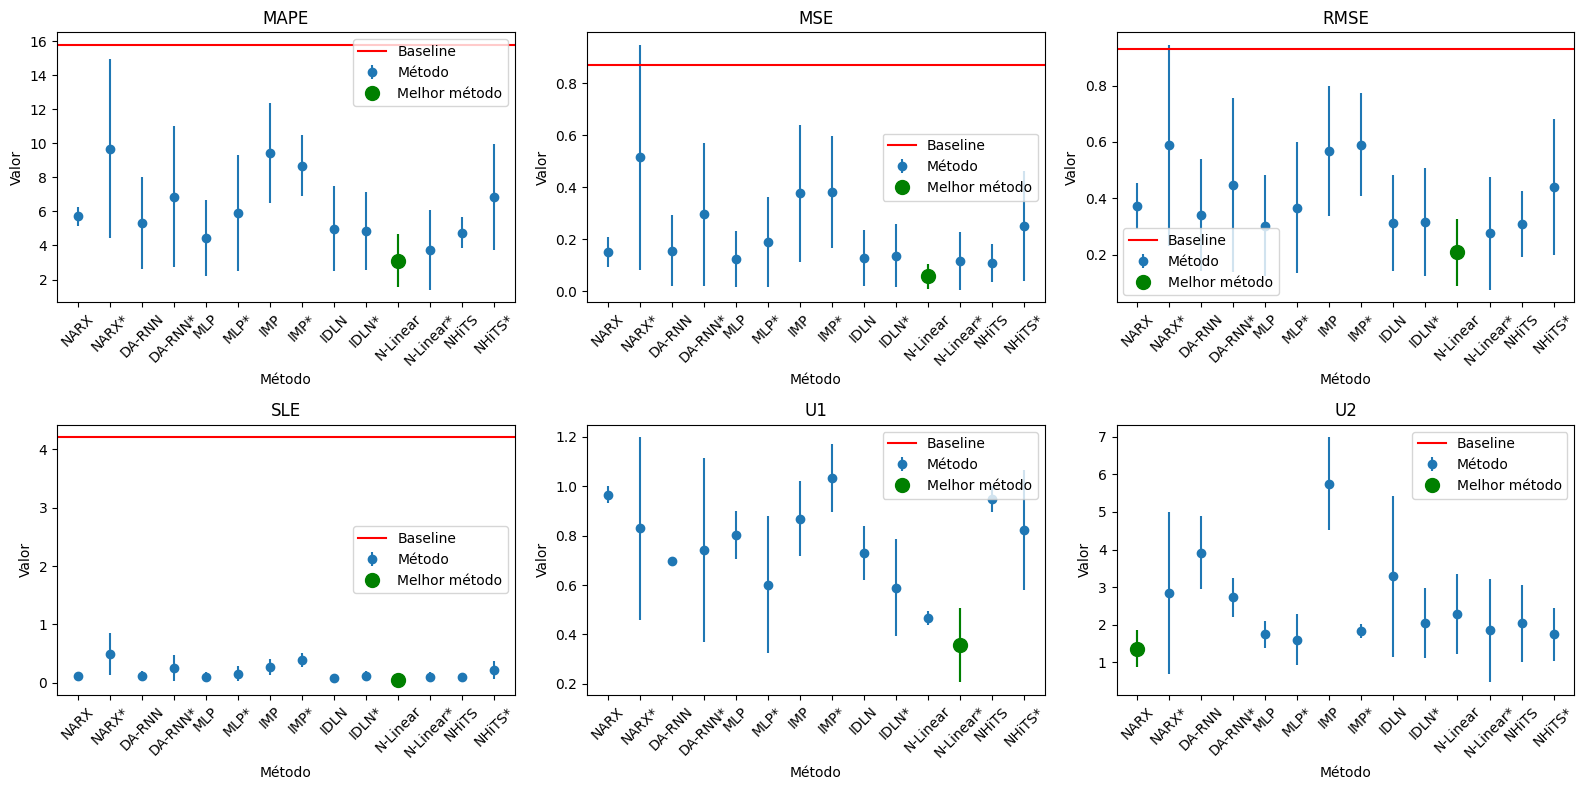

Biodiesel Nacional + Óleo de Soja


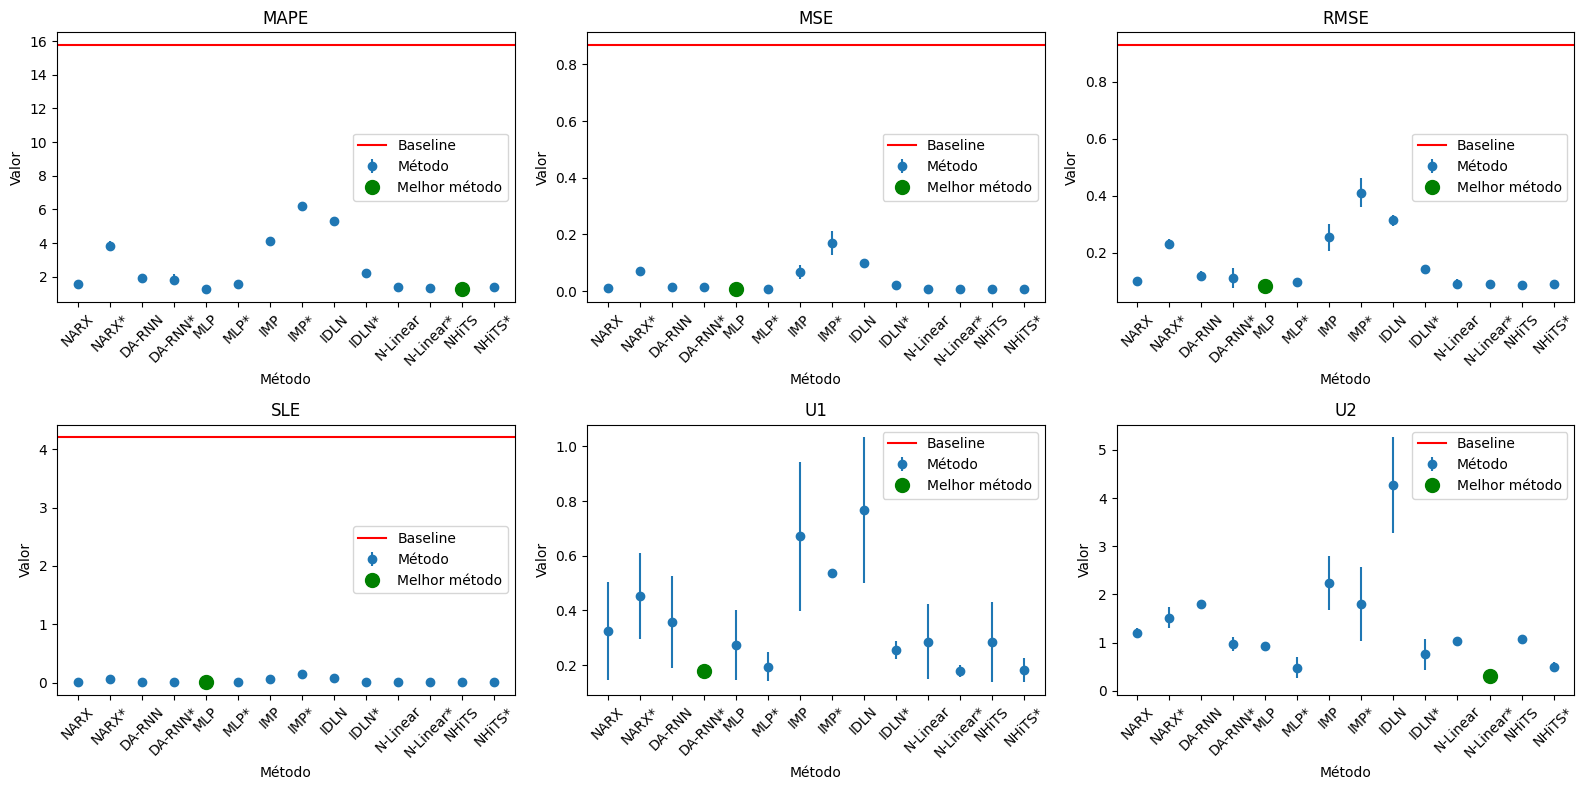

In [ ]:
print('Biodiesel Nacional')
plot_error(data_biodiesel, baseline_name = 'ARIMA')

print('Biodiesel Nacional + Óleo de Soja')
plot_error(data_biodiesel_soybean, baseline_name = 'ARIMA')

### Janela de Takens

In [ ]:
models = [('ARIMA', arima), ('NARX', narx_brasil_takens_cross_validation), ('NARX*', narx_brasil_detrend_takens_cross_validation), ('DA-RNN', darnn_brasil_takens_cross_validation), ('DA-RNN*', darnn_brasil_detrend_takens_cross_validation), ('MLP', mlp_brasil_takens_cross_validation), ('MLP*', mlp_brasil_detrend_takens_cross_validation), ('IMP', imp_brasil_takens_cross_validation), ('IMP*', imp_brasil_detrend_takens_cross_validation), ('IDLN', idln_brasil_takens_cross_validation), ('IDLN*', idln_brasil_detrend_takens_cross_validation), ('N-Linear', nlinear_brasil_takens_cross_validation), ('N-Linear*', nlinear_brasil_detrend_takens_cross_validation), ('NHiTS', nhits_brasil_takens_cross_validation), ('NHiTS*', nhits_brasil_detrend_takens_cross_validation)]

data_biodiesel = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel[metric].append(model[1][metric] if model[0] == "ARIMA" else model[1][metric][0])
    data_biodiesel[metric + '_std'].append(np.nan if model[0] == "ARIMA" else model[1][metric][1])

models = [('ARIMA', arima), ('NARX', narx_brasil_soybean_takens_cross_validation), ('NARX*', narx_brasil_soybean_detrend_takens_cross_validation), ('DA-RNN', darnn_brasil_soybean_takens_cross_validation), ('DA-RNN*', darnn_brasil_soybean_detrend_takens_cross_validation), ('MLP', mlp_brasil_soybean_takens_cross_validation), ('MLP*', mlp_brasil_soybean_detrend_takens_cross_validation), ('IMP', imp_brasil_soybean_takens_cross_validation), ('IMP*', imp_brasil_soybean_detrend_takens_cross_validation), ('IDLN', idln_brasil_soybean_takens_cross_validation), ('IDLN*', idln_brasil_soybean_detrend_takens_cross_validation), ('N-Linear', nlinear_brasil_soybean_takens_cross_validation), ('N-Linear*', nlinear_brasil_soybean_detrend_takens_cross_validation), ('NHiTS', nhits_brasil_soybean_takens_cross_validation), ('NHiTS*', nhits_brasil_soybean_detrend_takens_cross_validation)]

data_biodiesel_soybean = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel_soybean['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel_soybean[metric].append(model[1][metric] if model[0] == "ARIMA" else model[1][metric][0])
    data_biodiesel_soybean[metric + '_std'].append(np.nan if model[0] == "ARIMA" else model[1][metric][1])

Biodiesel Nacional


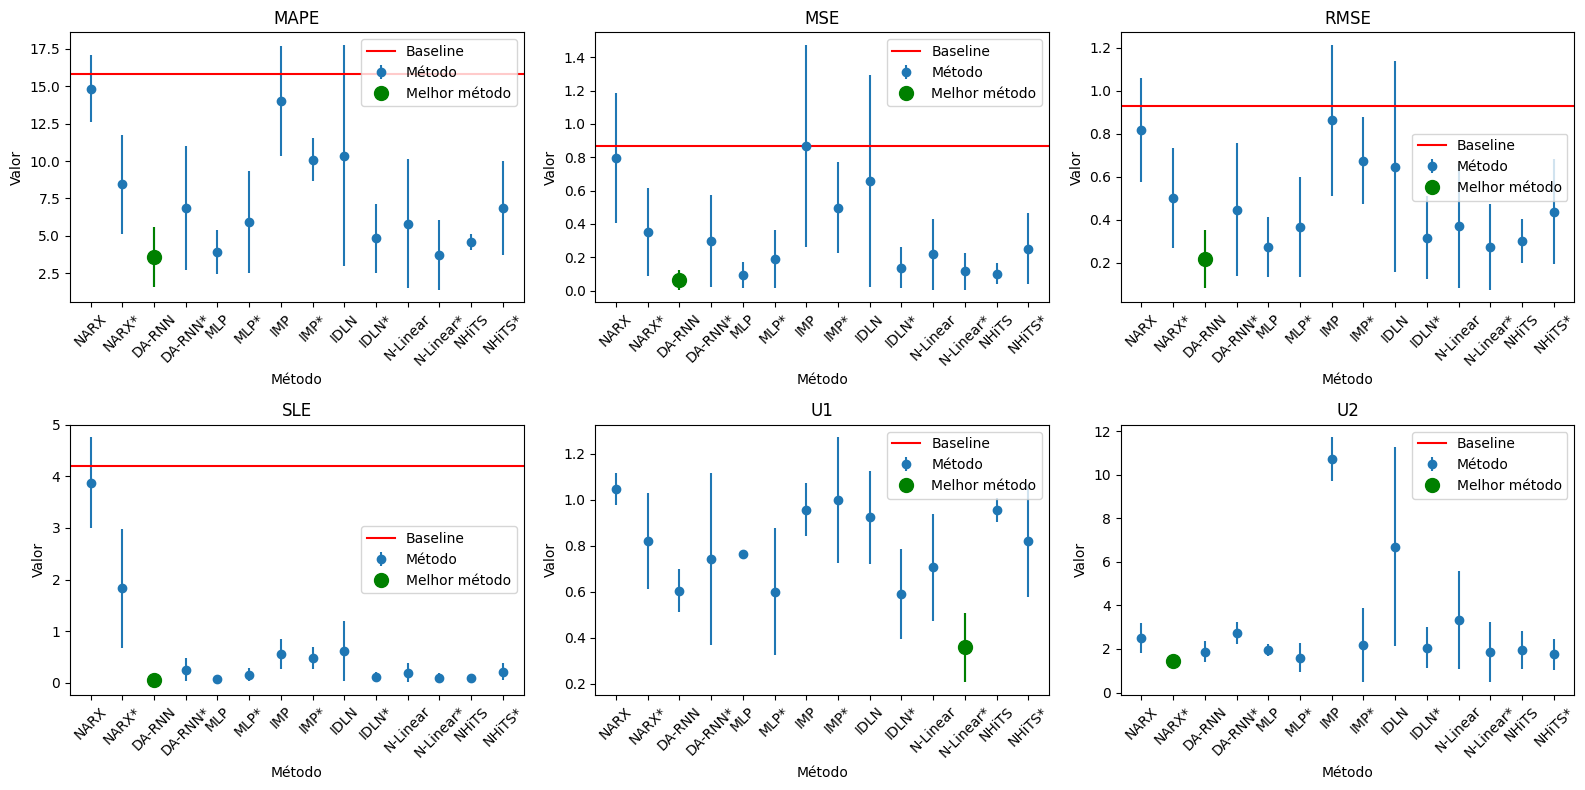

Biodiesel Nacional + Óleo de Soja


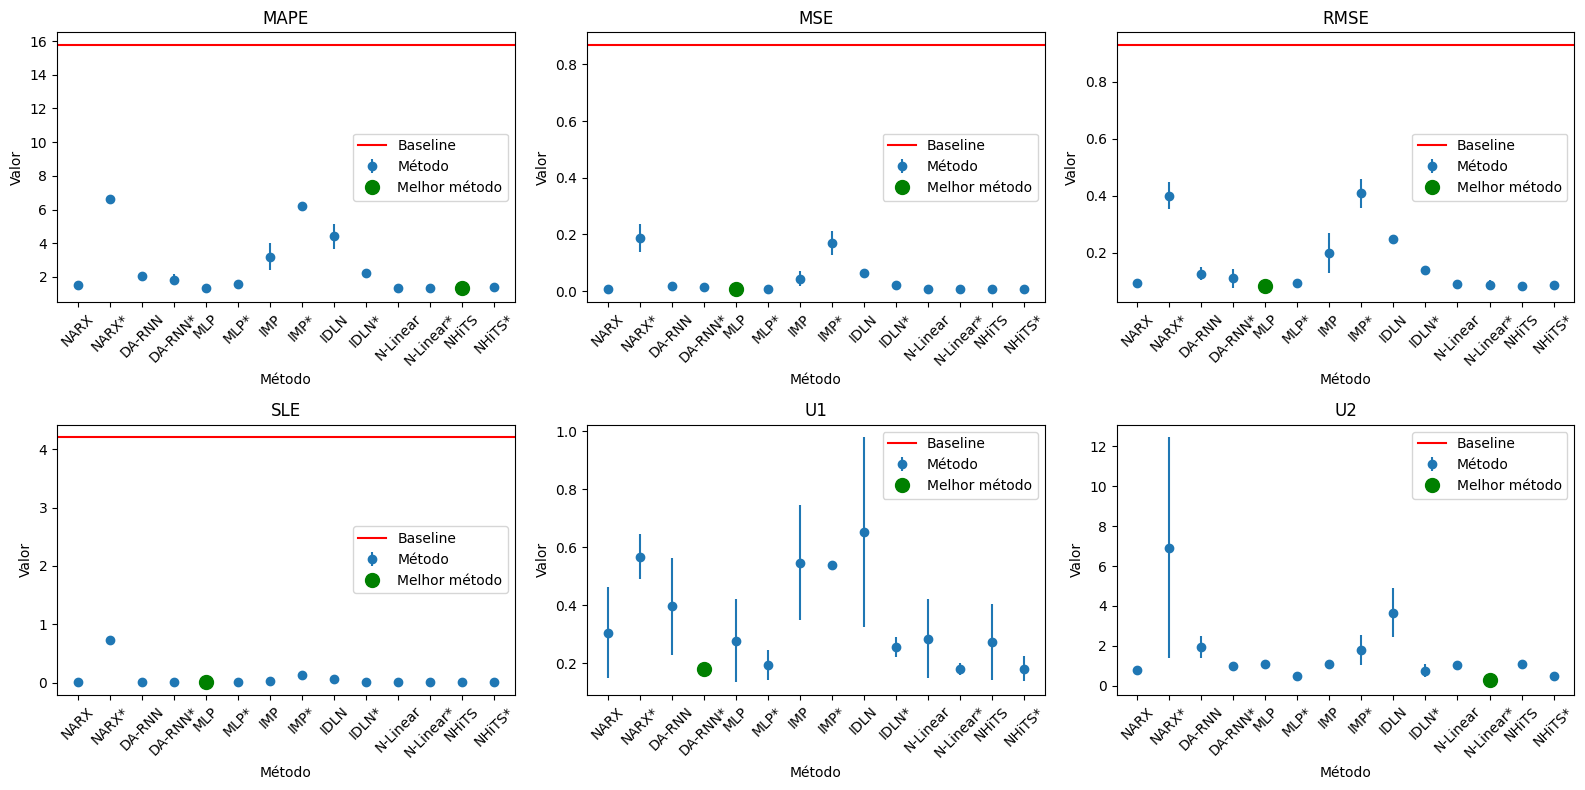

In [ ]:
print('Biodiesel Nacional')
plot_error(data_biodiesel, baseline_name = 'ARIMA')

print('Biodiesel Nacional + Óleo de Soja')
plot_error(data_biodiesel_soybean, baseline_name = 'ARIMA')

## Teste

### Janela Deslizante

In [ ]:
models = [('ARIMA', arima), ('NARX', narx_brasil_sliding_window_test), ('NARX*', narx_brasil_detrend_sliding_window_test), ('DA-RNN', darnn_brasil_sliding_window_test), ('DA-RNN*', darnn_brasil_detrend_sliding_window_test), ('MLP', mlp_brasil_sliding_window_test), ('MLP*', mlp_brasil_detrend_sliding_window_test), ('IMP', imp_brasil_sliding_window_test), ('IMP*', imp_brasil_detrend_sliding_window_test), ('IDLN', idln_brasil_sliding_window_test), ('IDLN*', idln_brasil_detrend_sliding_window_test), ('N-Linear', nlinear_brasil_sliding_window_test), ('N-Linear*', nlinear_brasil_detrend_sliding_window_test), ('NHiTS', nhits_brasil_sliding_window_test), ('NHiTS*', nhits_brasil_detrend_sliding_window_test)]

data_biodiesel = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel[metric].append(np.nan if model[0] == "ARIMA" else model[1][metric])
    data_biodiesel[metric + '_std'].append(np.nan)

models = [('ARIMA', arima), ('NARX', narx_brasil_soybean_sliding_window_test), ('NARX*', narx_brasil_soybean_detrend_sliding_window_test), ('DA-RNN', darnn_brasil_soybean_sliding_window_test), ('DA-RNN*', darnn_brasil_soybean_detrend_sliding_window_test), ('MLP', mlp_brasil_soybean_sliding_window_test), ('MLP*', mlp_brasil_soybean_detrend_sliding_window_test), ('IMP', imp_brasil_soybean_sliding_window_test), ('IMP*', imp_brasil_soybean_detrend_sliding_window_test), ('IDLN', idln_brasil_soybean_sliding_window_test), ('IDLN*', idln_brasil_soybean_detrend_sliding_window_test), ('N-Linear', nlinear_brasil_soybean_sliding_window_test), ('N-Linear*', nlinear_brasil_soybean_detrend_sliding_window_test), ('NHiTS', nhits_brasil_soybean_sliding_window_test), ('NHiTS*', nhits_brasil_soybean_detrend_sliding_window_test)]

data_biodiesel_soybean = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel_soybean['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel_soybean[metric].append(np.nan if model[0] == "ARIMA" else model[1][metric])
    data_biodiesel_soybean[metric + '_std'].append(np.nan)

Biodiesel Nacional


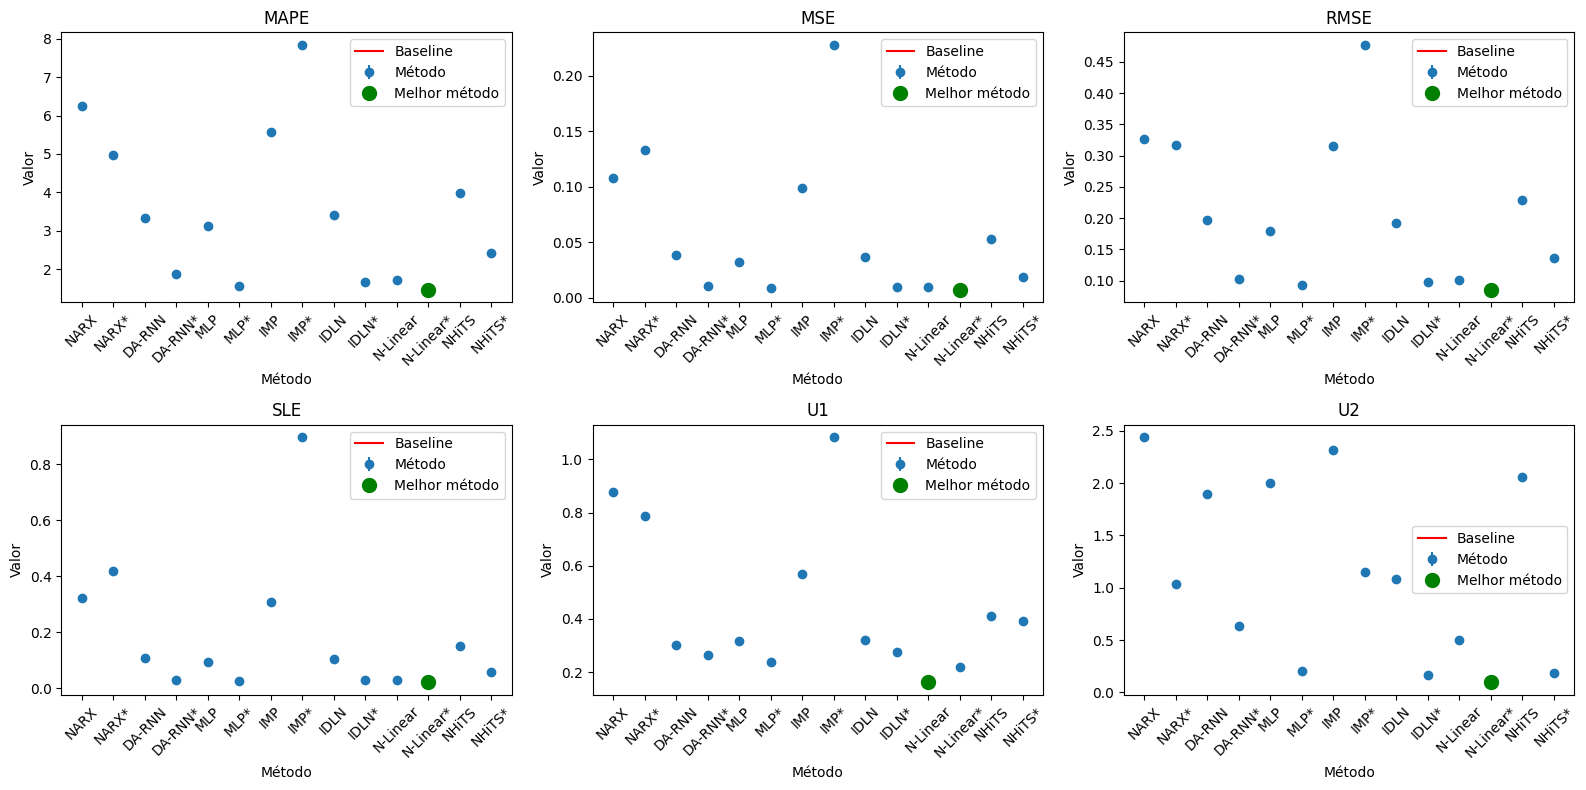

Biodiesel Nacional + Óleo de Soja


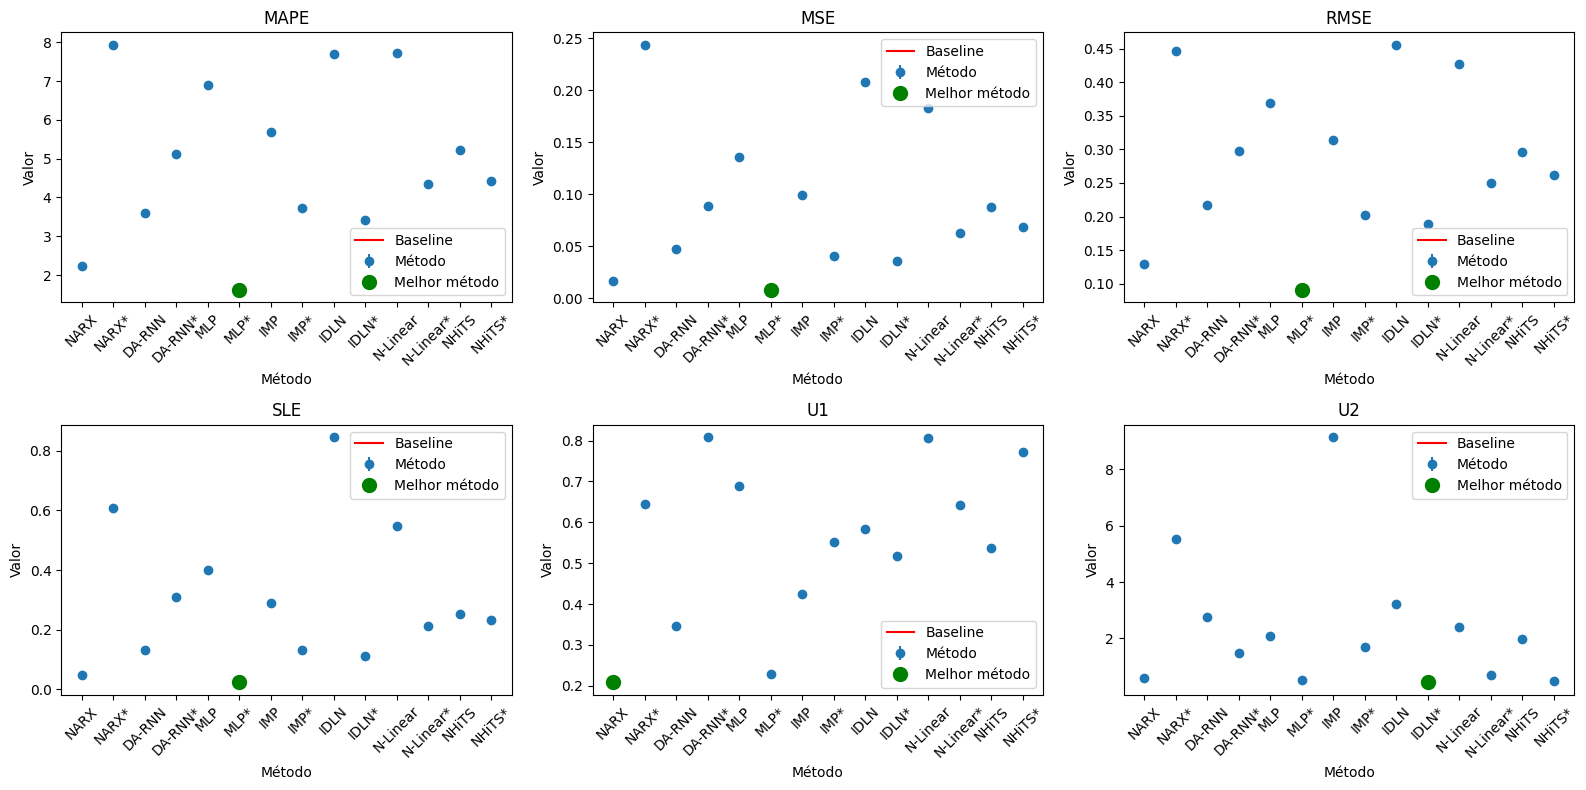

In [ ]:
print('Biodiesel Nacional')
plot_error(data_biodiesel, baseline_name = 'ARIMA')

print('Biodiesel Nacional + Óleo de Soja')
plot_error(data_biodiesel_soybean, baseline_name = 'ARIMA')

### Janela de Takens

In [ ]:
models = [('ARIMA', arima), ('NARX', narx_brasil_takens_test), ('NARX*', narx_brasil_detrend_takens_test), ('DA-RNN', darnn_brasil_takens_test), ('DA-RNN*', darnn_brasil_detrend_takens_test), ('MLP', mlp_brasil_takens_test), ('MLP*', mlp_brasil_detrend_takens_test), ('IMP', imp_brasil_takens_test), ('IMP*', imp_brasil_detrend_takens_test), ('IDLN', idln_brasil_takens_test), ('IDLN*', idln_brasil_detrend_takens_test), ('N-Linear', nlinear_brasil_takens_test), ('N-Linear*', nlinear_brasil_detrend_takens_test), ('NHiTS', nhits_brasil_takens_test), ('NHiTS*', nhits_brasil_detrend_takens_test)]

data_biodiesel = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel[metric].append(np.nan if model[0] == "ARIMA" else model[1][metric])
    data_biodiesel[metric + '_std'].append(np.nan)

models = [('ARIMA', arima), ('NARX', narx_brasil_soybean_takens_test), ('NARX*', narx_brasil_soybean_detrend_takens_test), ('DA-RNN', darnn_brasil_soybean_takens_test), ('DA-RNN*', darnn_brasil_soybean_detrend_takens_test), ('MLP', mlp_brasil_soybean_takens_test), ('MLP*', mlp_brasil_soybean_detrend_takens_test), ('IMP', imp_brasil_soybean_takens_test), ('IMP*', imp_brasil_soybean_detrend_takens_test), ('IDLN', idln_brasil_soybean_takens_test), ('IDLN*', idln_brasil_soybean_detrend_takens_test), ('N-Linear', nlinear_brasil_soybean_takens_test), ('N-Linear*', nlinear_brasil_soybean_detrend_takens_test), ('NHiTS', nhits_brasil_soybean_takens_test), ('NHiTS*', nhits_brasil_soybean_detrend_takens_test)]

data_biodiesel_soybean = {
    'Modelo': [],
    'MAPE': [],
    'MAPE_std': [],
    'MSE': [],
    'MSE_std': [],
    'RMSE': [],
    'RMSE_std': [],
    'SLE': [],
    'SLE_std': [],
    'U1': [],
    'U1_std': [],
    'U2': [],
    'U2_std': []
}

metrics = ['MAPE', 'MSE', 'RMSE', 'SLE', 'U1', 'U2']

for model in models:
  data_biodiesel_soybean['Modelo'].append(model[0])
  for metric in metrics:
    data_biodiesel_soybean[metric].append(np.nan if model[0] == "ARIMA" else model[1][metric])
    data_biodiesel_soybean[metric + '_std'].append(np.nan)

Biodiesel Nacional


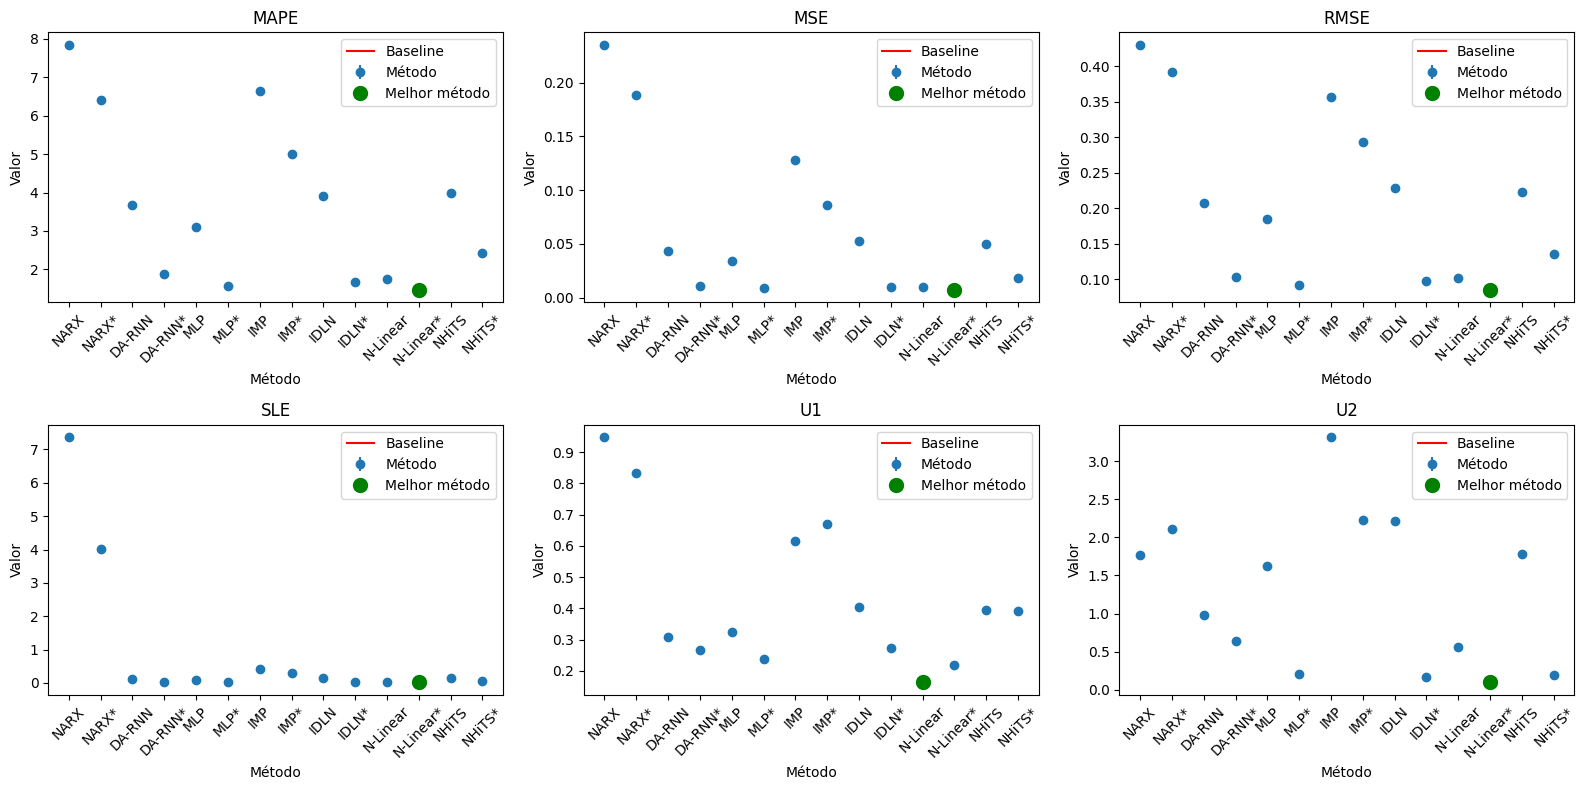

Biodiesel Nacional + Óleo de Soja


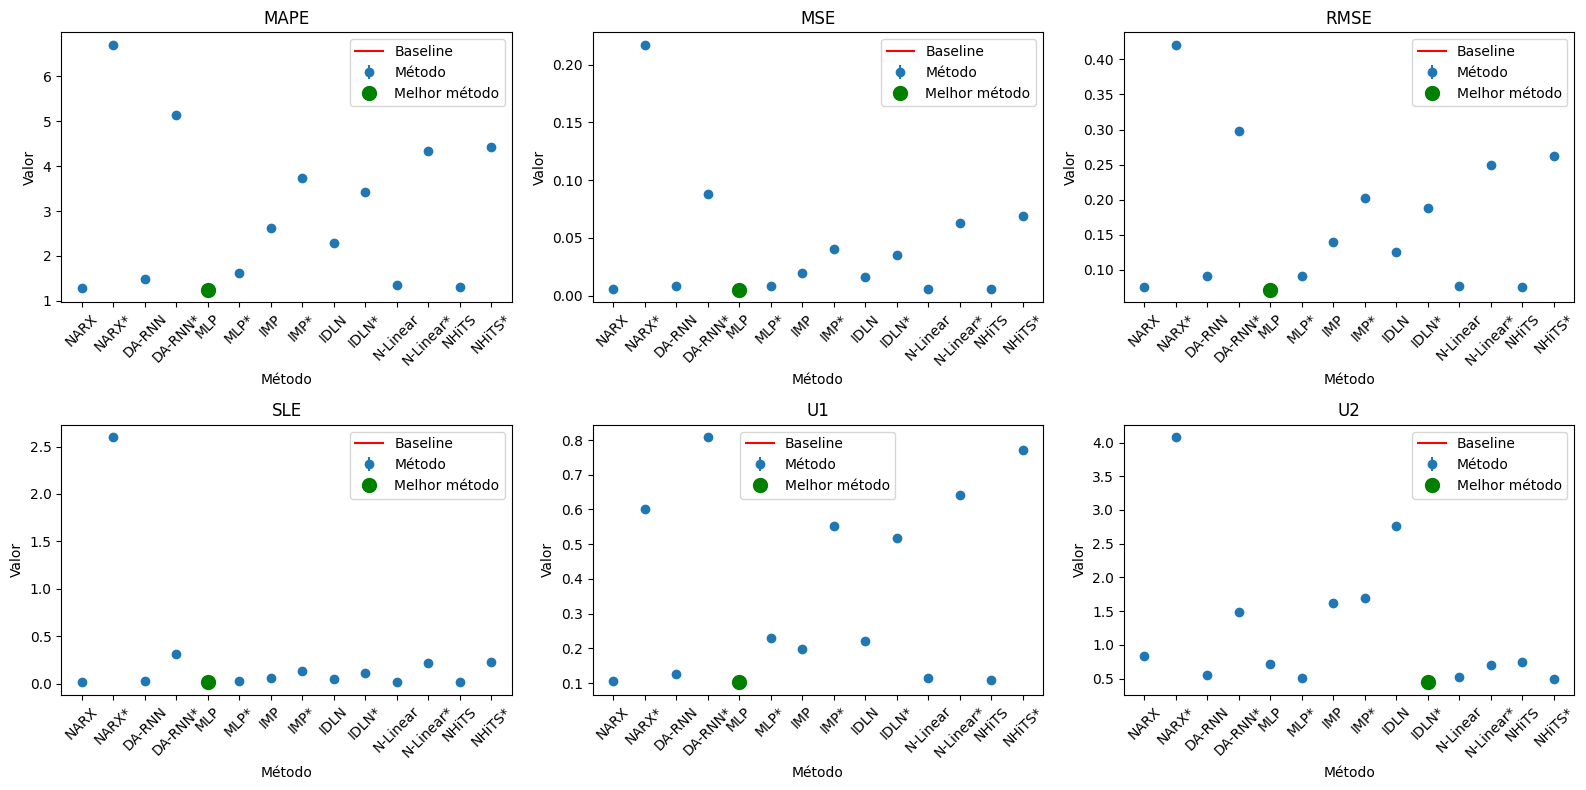

In [ ]:
print('Biodiesel Nacional')
plot_error(data_biodiesel, baseline_name = 'ARIMA')

print('Biodiesel Nacional + Óleo de Soja')
plot_error(data_biodiesel_soybean, baseline_name = 'ARIMA')

# Tabelas

In [ ]:
#Janela deslizante - Validação Cruzada

metricas = ['MAPE', 'SLE', 'MSE', 'RMSE', 'U1', 'U2']
datasets = ['Biodiesel Nacional', 'Biodiesel Nacional + Óleo de Soja']
dados = {
    'ARIMA': {'': {
        'Biodiesel Nacional': arima,
        'Biodiesel Nacional + Óleo de Soja': {'MAPE': np.nan, 'SLE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'U1': np.nan, 'U2': np.nan}
    }},
    'NARX': {
        'Original': {
            'Biodiesel Nacional': narx_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': narx_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
    'DA-RNN': {
        'Original': {
            'Biodiesel Nacional': darnn_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': darnn_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
    'MLP': {
        'Original': {
            'Biodiesel Nacional': mlp_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': mlp_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
    'IMP': {
        'Original': {
            'Biodiesel Nacional': imp_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': imp_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
    'IDLN': {
        'Original': {
            'Biodiesel Nacional': idln_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': idln_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
    'N-Linear': {
        'Original': {
            'Biodiesel Nacional': nlinear_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': nlinear_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
    'NHiTS': {
        'Original': {
            'Biodiesel Nacional': nhits_brasil_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_sliding_window_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': nhits_brasil_detrend_sliding_window_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_detrend_sliding_window_cross_validation
        }
    },
}
with open('resultados_validacao.tex', 'w') as f:
  f.write(generate_latex_table(dados, metricas, datasets, 2))


In [ ]:
#Janela deslizante - Teste

metricas = ['MAPE', 'SLE', 'MSE', 'RMSE', 'U1', 'U2']
datasets = ['Biodiesel Nacional', 'Biodiesel Nacional + Óleo de Soja']
dados = {
    'NARX': {
        'Original': {
            'Biodiesel Nacional': narx_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': narx_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_detrend_sliding_window_test
        }
    },
    'DA-RNN': {
        'Original': {
            'Biodiesel Nacional': darnn_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': darnn_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_detrend_sliding_window_test
        }
    },
    'MLP': {
        'Original': {
            'Biodiesel Nacional': mlp_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': mlp_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_detrend_sliding_window_test
        }
    },
    'IMP': {
        'Original': {
            'Biodiesel Nacional': imp_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': imp_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_detrend_sliding_window_test
        }
    },
    'IDLN': {
        'Original': {
            'Biodiesel Nacional': idln_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': idln_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_detrend_sliding_window_test
        }
    },
    'N-Linear': {
        'Original': {
            'Biodiesel Nacional': nlinear_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': nlinear_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_detrend_sliding_window_test
        }
    },
    'NHiTS': {
        'Original': {
            'Biodiesel Nacional': nhits_brasil_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_sliding_window_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': nhits_brasil_detrend_sliding_window_test,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_detrend_sliding_window_test
        }
    },
}
with open('resultados_teste.tex', 'w') as f:
  f.write(generate_latex_table(dados, metricas, datasets, 2))


In [ ]:
#Janela de Takens - Validação Cruzada

metricas = ['MAPE', 'SLE', 'MSE', 'RMSE', 'U1', 'U2']
datasets = ['Biodiesel Nacional', 'Biodiesel Nacional + Óleo de Soja']
dados = {
    'ARIMA': {'': {
        'Biodiesel Nacional': arima,
        'Biodiesel Nacional + Óleo de Soja': {'MAPE': np.nan, 'SLE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'U1': np.nan, 'U2': np.nan}
    }},
    'NARX': {
        'Original': {
            'Biodiesel Nacional': narx_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': narx_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_detrend_takens_cross_validation
        }
    },
    'DA-RNN': {
        'Original': {
            'Biodiesel Nacional': darnn_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': darnn_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_detrend_takens_cross_validation
        }
    },
    'MLP': {
        'Original': {
            'Biodiesel Nacional': mlp_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': mlp_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_detrend_takens_cross_validation
        }
    },
    'IMP': {
        'Original': {
            'Biodiesel Nacional': imp_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': imp_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_detrend_takens_cross_validation
        }
    },
    'IDLN': {
        'Original': {
            'Biodiesel Nacional': idln_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': idln_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_detrend_takens_cross_validation
        }
    },
    'N-Linear': {
        'Original': {
            'Biodiesel Nacional': nlinear_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': nlinear_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_detrend_takens_cross_validation
        }
    },
    'NHiTS': {
        'Original': {
            'Biodiesel Nacional': nhits_brasil_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_takens_cross_validation
        },
        'Sem tendência': {
            'Biodiesel Nacional': nhits_brasil_detrend_takens_cross_validation,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_detrend_takens_cross_validation
        }
    },
}
with open('resultados_validacao_takens.tex', 'w') as f:
  f.write(generate_latex_table(dados, metricas, datasets, 2))


In [ ]:
#Janela de Takens - Teste

metricas = ['MAPE', 'SLE', 'MSE', 'RMSE', 'U1', 'U2']
datasets = ['Biodiesel Nacional', 'Biodiesel Nacional + Óleo de Soja']
dados = {
    'NARX': {
        'Original': {
            'Biodiesel Nacional': narx_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': narx_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': narx_brasil_soybean_detrend_takens_test
        }
    },
    'DA-RNN': {
        'Original': {
            'Biodiesel Nacional': darnn_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': darnn_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': darnn_brasil_soybean_detrend_takens_test
        }
    },
    'MLP': {
        'Original': {
            'Biodiesel Nacional': mlp_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': mlp_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': mlp_brasil_soybean_detrend_takens_test
        }
    },
    'IMP': {
        'Original': {
            'Biodiesel Nacional': imp_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': imp_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': imp_brasil_soybean_detrend_takens_test
        }
    },
    'IDLN': {
        'Original': {
            'Biodiesel Nacional': idln_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': idln_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': idln_brasil_soybean_detrend_takens_test
        }
    },
    'N-Linear': {
        'Original': {
            'Biodiesel Nacional': nlinear_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': nlinear_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': nlinear_brasil_soybean_detrend_takens_test
        }
    },
    'NHiTS': {
        'Original': {
            'Biodiesel Nacional': nhits_brasil_takens_test,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_takens_test
        },
        'Sem tendência': {
            'Biodiesel Nacional': nhits_brasil_detrend_takens_test,
            'Biodiesel Nacional + Óleo de Soja': nhits_brasil_soybean_detrend_takens_test
        }
    },
}
with open('resultados_teste_takens.tex', 'w') as f:
  f.write(generate_latex_table(dados, metricas, datasets, 2))
